In [1]:
# !pip install googletrans==3.1.0a0

In [3]:
import json
import time
import base64
import requests
import os
import threading
import random
import cv2
import googletrans
from googletrans import Translator
import numpy as np
import math
from matplotlib import pyplot as plt

# Всякий код

## ГЕНЕРАЦИЯ ИЗОБРАЖЕНИЙ

In [5]:
def rotate_img(image):
    ind = random.choice([0, 1, 2, 3])
    if ind == 0:
        res = image
    elif ind == 1:
        res = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif ind == 2:
        res = cv2.rotate(image, cv2.ROTATE_180)
    else:
        res = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return res


def translate_text(text):
    translator = Translator()
    translated_ita = translator.translate(text, src='ru', dest='en')
    tr_obj = translated_ita.text
    return tr_obj


# ------------------------------------ГЕНЕРАЦИЯ---------------------------------------------------
class Text2ImageAPI:
    def __init__(self, url, api_key, secret_key):
        self.URL = url
        self.AUTH_HEADERS = {
            'X-Key': f'Key {api_key}',
            'X-Secret': f'Secret {secret_key}',
        }

    def get_model(self):
        response = requests.get(self.URL + 'key/api/v1/models', headers=self.AUTH_HEADERS)
        data = response.json()
        return data[0]['id']

    def generate(self, prompt, model, images=1, width=512, height=512):
        params = {
            "type": "GENERATE",
            "numImages": images,
            "width": width,
            "height": height,
            "style": "UHD",
            "negativePromptUnclip": "неравномерное освещение, тени, блики, блеск, капли, неравномерная яркость,\
                                            неравномерный задний план, объём",
            "generateParams": {
                "query": f"{prompt}"
            }
        }

        data = {
            'model_id': (None, model),
            'params': (None, json.dumps(params), 'application/json')
        }
        response = requests.post(self.URL + 'key/api/v1/text2image/run', headers=self.AUTH_HEADERS, files=data)
        data = response.json()
        return data['uuid']

    def check_generation(self, request_id, attempts=50, delay=50):
        while attempts > 0:
            response = requests.get(self.URL + 'key/api/v1/text2image/status/' + request_id, headers=self.AUTH_HEADERS)
            data = response.json()
            if data['status'] == 'DONE':
                return data['images']

            attempts -= 1
            time.sleep(delay)


def generate_images(api, promt, i, model_id, folder, imsize, mode, neg_path):
    uuid = api.generate(promt, model_id, width=imsize, height=imsize)
    images = api.check_generation(uuid)
    img_b = base64.b64decode(images[0])
    # запись в папку
    with open(f'{folder}/image{i}.png', 'wb') as f:
        f.write(img_b)

    image = cv2.imread(f'{folder}/image{i}.png')
    res = rotate_img(image)
    cv2.imwrite(f'{folder}/image{i}.png', res)

    if mode=="тёмный":
        image = cv2.imread(f'{folder}/image{i}.png')
        img_neg = cv2.bitwise_not(image)
        cv2.imwrite(f'{neg_path}/image{i}.png', img_neg)

    print(f'картинка с номером {i} была сгенерирована.')


def _generate_(obj, img_count, promts, imsize):
    api = Text2ImageAPI('https://api-key.fusionbrain.ai/', '8EDD04A0A3339391D3DA04FC947801CB',
                        'F29E43D7A9EB9C60C34C1B45ABFF2104')
    model_id = api.get_model()

    # создаём папку, если такой нет
    tr_obj = translate_text(obj)

    path_orig = f'images/{tr_obj}/original'
    neg_path = f'images/{tr_obj}/negative'
    
    if not (os.path.exists(path_orig)):
        os.makedirs(path_orig)

    if not (os.path.exists(neg_path)):
        os.makedirs(neg_path)
    
    if img_count < 500:
        n = 10
    else:
        n = 200  # число разбиения потоков

    count = math.trunc(img_count / n)
    mod = img_count % n

    num = -1

    if img_count >= n:
        for j in range(n):
            for i in range(count):
                num = i + j * count
                print(f"image{num} started to generate")
                thread = threading.Thread(target=generate_images, args=(api, promts[0], num, model_id, path_orig, imsize,  neg_path))
                thread.start()
            time.sleep(13)

    if mod != 0:
        for i in range(num + 1, num + mod + 1):
            print(f"image{i} started to generate: {promts[0]}")
            thread = threading.Thread(target=generate_images, args=(api, promts[0], i, model_id, path_orig, imsize, neg_path))
            thread.start()
    # -----------------------------------------------------------------------------------------------------------------


# def generate_promts(obj, img_count):
#     promts = []


#         colors = {
#             'бордовый': [-1],
#             'тёмно-зелёный': [-2],
#             'тёмно-синий': [-3, -6],
#             'чёрный': [-5, -8],
#             'жёлтый': [-9]
#         }
#         back_color = {
#             'бежевый': [6],
#             'белый': [1, 2, 3, 4, 5, 9],
#             'светло-жёлтый': [8],
#             'ярко-белый': [1, 2, 9]
#         }
#         for i in range(img_count):
#             color = random.choice(list(colors.keys()))
#             ind = random.choice(colors[color])
#             # print(f'{color}: {ind}')
#             ncolors = []
#             # print(colors.items())
#             for key, val in back_color.items():
#                 for v in val:
#                     if v == -ind:
#                         ncolors.append(key)
#             back = random.choice(ncolors)
#             promt = f"матовый {color} {obj} на матовом {back} фоне."
#             promts.append(promt)
            
#     elif mode == "тёмный":
#         colors={
#             'тёмно-синий':[3],
#             'чёрный': [1, 2, 4, 5, 6, 7, 8]
#         }
#         back_color = { 
#             'светло-жёлтый':[-5],
#             'ярко-жёлтый':[-2],
#             'ярко-белый':[-3, -4],
#             'светло-розовый': [-6],
#             'светло-зелёный': [-8],
#         }
#         for i in range(img_count):
#             color = random.choice(list(back_color.keys()))
#             ind = random.choice(back_color[color])
#             # print(f'{color}: {ind}')
#             ncolors = []
#             # print(colors.items())
#             for key, val in colors.items():
#                 for v in val:
#                     if v == -ind:
#                         ncolors.append(key)
#             back = random.choice(ncolors)
#             promt = f"матовый {color} {obj} на матовом {back} фоне."
#             promts.append(promt)
#     return promts


# ------------------------------------------------------------------------------------------------
if __name__ == '__main__':
    obj = "череп"
    img_count = 1000
    mode = "тёмный"
    imsize = 512
    # --------------------------- генерация промтов ----------------------------------
    # promts = generate_promts(obj, img_count) 
    promts = ['череп']
    # --------------------------------------------------------------------------------
    
    # --------------------------------- генерация изображений -----------------------
    _generate_(obj, img_count, promts, imsize) 
    # -------------------------------------------------------------------------------



Exception in thread Thread-6 (generate_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
TypeError: generate_images() missing 1 required positional argument: 'neg_path'
Exception in thread Thread-7 (generate_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-8 (generate_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.r

image0 started to generate
image1 started to generate
image2 started to generate
image3 started to generate
image4 started to generate


Exception in thread Thread-11 (generate_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-12 (generate_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
Exception in thread Thread-13 (generate_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 761, in 

image5 started to generate
image6 started to generate
image7 started to generate
image8 started to generate
image9 started to generate


Exception in thread Thread-16 (generate_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
Exception in thread Thread-17 (generate_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    _threading_Thread_run(self)
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
Exception in thread Thread-18 (generate_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _boot

image10 started to generate
image11 started to generate
image12 started to generate
image13 started to generate
image14 started to generate


Exception in thread Thread-21 (generate_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
Exception in thread Thread-22 (generate_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
Exception in thread Thread-23 (generate_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    _threading_Thread_run(self)
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 

image15 started to generate
image16 started to generate
image17 started to generate
image18 started to generate
image19 started to generate


KeyboardInterrupt: 

##  старое

In [14]:
class Text2ImageAPI:
    def __init__(self, url, api_key, secret_key):
        self.URL = url
        self.AUTH_HEADERS = {
            'X-Key': f'Key {api_key}',
            'X-Secret': f'Secret {secret_key}',
        }

    def get_model(self):
        response = requests.get(self.URL + 'key/api/v1/models', headers=self.AUTH_HEADERS)
        data = response.json()
        return data[0]['id']

    def generate(self, prompt, model, images=1, width=1024, height=1024):
        params = {
            "type": "GENERATE",
            "numImages": images,
            "width": width,
            "height": height,
            "style": "DEFAULT",
            "negativePromptUnclip": "неравномерное освещение, тени, блики, блеск, капли, неравномерная яркость,\
                                    неравномерный задний план, объём",
            "generateParams": {
                "query": f"{prompt}"
            }
        }

        data = {
            'model_id': (None, model),
            'params': (None, json.dumps(params), 'application/json')
        }
        response = requests.post(self.URL + 'key/api/v1/text2image/run', headers=self.AUTH_HEADERS, files=data)
        data = response.json()
        return data['uuid']

    def check_generation(self, request_id, attempts=20, delay=20):
        while attempts > 0:
            response = requests.get(self.URL + 'key/api/v1/text2image/status/' + request_id, headers=self.AUTH_HEADERS)
            data = response.json()
            if data['status'] == 'DONE':
                return data['images']

            attempts -= 1
            time.sleep(delay)


# ф-ция генерации изобр.; вх - объект класса нейросети, промт, идент. модели, папка сохранения изобр.; вых - нет. 
def generate_images(api, promt, i, model_id, folder, imsize):
    uuid = api.generate(promt, model_id, width=imsize, height=imsize)
    images = api.check_generation(uuid)
    img_b = base64.b64decode(images[0])
    # запись в папку
    with open(f'{folder}/image{i}.png', 'wb') as f:
        f.write(img_b)

    image = cv2.imread(f'{folder}/image{i}.png')
    res = rotate_img(image)
    cv2.imwrite(f'{folder}/image{i}.png', res)

    print(f'картинка с номером {i} была сгенерирована. {promt}')

def generate(obj, img_count, promts):
    api = Text2ImageAPI('https://api-key.fusionbrain.ai/', '8EDD04A0A3339391D3DA04FC947801CB', 'F29E43D7A9EB9C60C34C1B45ABFF2104')
    model_id = api.get_model()

    # создаём папку, если такой нет
    translator = Translator()
    translated_ita = translator.translate(obj, src='ru', dest='en')
    tr_obj = translated_ita.text

    path_orig = f'images/{tr_obj}/original'
    if not(os.path.exists(path_orig)):
        os.makedirs(path_orig)

    n = 50 # число разбиения потоков
    count = math.trunc(img_count/n) 
    mod = img_count%n  
    
    # count = 0

    # for i in range(img_count):
    #     thread = threading.Thread(target=generate_images, args=(api, promts[i], i, model_id, path_orig))
    #     thread.start()
    #     count+=1
    #     if count == 200:
    #         time.sleep(5)
    #         count = 0

    num=-1

    for j in range(n):  
        for i in range(count):
            num = i+j*count
            print(f"image{num} started to generate: {promts[num]}")
            thread = threading.Thread(target=generate_images, args=(api, promts[num], num, model_id, path_orig))
            thread.start()
        # time.sleep(10)

    if mod != 0:
       for i in range(num+1, num+mod+1):
            print(f"image{i} started to generate: {promts[i]}")
            thread = threading.Thread(target=generate_images, args=(api, promts[i], i, model_id, path_orig))
            thread.start() 
# -----------------------------------------------------------------------------------------------------------------
        
# ф-ция генерации промтов; вх - генерируемый объект, кол-во изобр.; вых - массив промтов. 
def generate_promts(obj, img_count):
    promts = [] 
    colors={
            'бордовый':[1], 
            'тёмно-зелёный':[2],
            'тёмно-синий':[3],
            'чёрный': [4, 5, 6, 7, 8]
           }
    back_color = { 
        'светло-жёлтый':[-5],
        'ярко-белый':[-1, -2, -3],
        'розовый': [-6],
        'светло-голубой': [-7],
        'светло-зелёный': [-8]
    }
    for i in range(img_count):
        color = random.choice(list(colors.keys()))
        ind = random.choice(colors[color])
        # print(f'{color}: {ind}')
        ncolors = []
        # print(colors.items())
        for key, val in back_color.items():
            for v in val:
                if v == -ind: ncolors.append(key)
        back = random.choice(ncolors)
        promt = f"матовый {color} {obj} на матовом {back} фоне."
        promts.append(promt)
    return promts
# -------------------------------------------------------------------------------------------------------
def back_images(api, promt, i, model_id, folder, imsize):
    uuid = api.generate(promt, model_id, width=imsize, height=imsize)
    images = api.check_generation(uuid)
    img_b = base64.b64decode(images[0])
    # запись в папку
    with open(f'{folder}/image{i}.png', 'wb') as f:
        f.write(img_b)

    print(f'картинка с номером {i} была сгенерирована. {promt}')

def generate_backs(img_count, promts, imsize):
    api = Text2ImageAPI('https://api-key.fusionbrain.ai/', '8EDD04A0A3339391D3DA04FC947801CB', 'F29E43D7A9EB9C60C34C1B45ABFF2104')
    model_id = api.get_model()

    path_orig = f'images/backgrounds_1'
    if not(os.path.exists(path_orig)):
        os.makedirs(path_orig)
   
    # for i in range(count):
    #     promt = random.choice(list(promts)) + " фон"
    #     print(f"image{i} started to generate: {promt}")
    #     thread = threading.Thread(target=generate_images, args=(api, promt, i, model_id, path_orig))
    #     thread.start()
    #     # time.sleep(10)

    if img_count < 500:
        n = 10
    else:
        n = 200  # число разбиения потоков

    count = math.trunc(img_count / n)
    mod = img_count % n

    num = -1

    if img_count >= n:
        for j in range(n):
            for i in range(count):
                promt = random.choice(list(promts)) + " фон"
                num = i + j * count
                print(f"image{num} started to generate: {promt}")
                thread = threading.Thread(target=back_images, args=(api, promt, num, model_id, path_orig, imsize))
                thread.start()
            time.sleep(13)

    if mod != 0:
        for i in range(num + 1, num + mod + 1):
            promt = random.choice(list(promts)) + " фон"
            print(f"image{i} started to generate: {promt}")
            thread = threading.Thread(target=back_images, args=(api, promt, i, model_id, path_orig, imsize))
            thread.start()
# -----------------------------------------------------------------------------------------------------------------
        



# backgrounds = {"деревянный", "белый", "чёрный", "синий", "красный", "фиолетовый", "зелёный", "жёлтый", "бежевый",
#               "оранжевый", "изумрудный", "серый", "металлический", "розовый", "голубой", "салатовый", "бордовый",
#               "тёмно-синий", "тёмно-зелёный", "светло-зелёный", "травяной", "светло-серый", "небесный", "коричневый",
#               "светло-синий", "нежно-розовый", "матовый белый", ""}


backgrounds = {"светлый деревянный", "тёмный деревянный", "светлый деревянный", "тёмный деревянный", "светлый деревянный", "тёмный деревянный"}

# obj = 'ваза' # TODO: бутет задаваться пользователем через GUI 
# img_count = 4


if __name__ == '__main__':
    # # --------------------------- исходные параметры ---------------------------------
    
    # # TODO: добавить параметры размеров изображения и стиля(?)
    # # --------------------------------------------------------------------------------
    
    # # --------------------------- генерация промтов ----------------------------------
    # promts = generate_promts(obj, img_count) 
    # # print(promts)
    # # --------------------------------------------------------------------------------
    
    # # --------------------------------- генерация изображений -----------------------
    # generate(obj, img_count, promts)      
    # # -------------------------------------------------------------------------------

   generate_backs(300, backgrounds, 512)
        


image0 started to generate: светлый деревянный фон
image1 started to generate: тёмный деревянный фон
image2 started to generate: светлый деревянный фон
image3 started to generate: тёмный деревянный фон
image4 started to generate: светлый деревянный фон
image5 started to generate: тёмный деревянный фон
image6 started to generate: светлый деревянный фон
image7 started to generate: тёмный деревянный фон
image8 started to generate: тёмный деревянный фон
image9 started to generate: тёмный деревянный фон
image10 started to generate: светлый деревянный фон
image11 started to generate: тёмный деревянный фон
image12 started to generate: светлый деревянный фон
image13 started to generate: тёмный деревянный фон
image14 started to generate: светлый деревянный фон
image15 started to generate: светлый деревянный фон
image16 started to generate: светлый деревянный фон
image17 started to generate: тёмный деревянный фон
image18 started to generate: тёмный деревянный фон
image19 started to generate: тём

Exception in thread Thread-386 (back_images):
Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connection.py", line 203, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "C:\Users\iraor\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
TimeoutError: [WinError 10060] Попытка установить соединение была безуспешной, т.к. от другого компьютера за требуемое время не получен нужный отклик, или было разорвано уже установленное соединение из-за неверного отклика уже подключенного компьютера

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\iraor\AppData\Local

image240 started to generate: тёмный деревянный фон
image241 started to generate: тёмный деревянный фон
image242 started to generate: светлый деревянный фон
image243 started to generate: тёмный деревянный фон
image244 started to generate: светлый деревянный фон
image245 started to generate: тёмный деревянный фон
image246 started to generate: светлый деревянный фон
image247 started to generate: тёмный деревянный фон
image248 started to generate: светлый деревянный фон
image249 started to generate: светлый деревянный фон
image250 started to generate: тёмный деревянный фон
image251 started to generate: тёмный деревянный фон
image252 started to generate: светлый деревянный фон
image253 started to generate: светлый деревянный фон
image254 started to generate: светлый деревянный фон
image255 started to generate: тёмный деревянный фон
image256 started to generate: светлый деревянный фон
image257 started to generate: светлый деревянный фон
image258 started to generate: тёмный деревянный фон
im

## АЛГОРИТМЫ СЕГМЕНТАЦИИ

In [8]:
# -------------------алгоритмы сегментации + алгоритмы обработки изобр. ---------------
def write_img(path, img_name, func_name, image):
    cv2.imwrite(f'{path}_{func_name}\\{img_name}.jpg', image)

def grey_img(image):
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return img_grey

def blur_gauss(image):
    blur = cv2.GaussianBlur(image,(19,19),0)
    return blur


def otsu_threshold(image):
    grey_image = grey_img(image)
    ret, otsu = cv2.threshold(grey_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return otsu


def watershed_img(image):
    src = image
    img = src.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # Устранение шума
    kernel = np.ones((2, 2), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    # Устранение дырок
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)
    # Расширение
    sure_bg = cv2.dilate(closing, kernel, iterations=3)
    # Преобразование расстояния
    sure_fg = cv2.erode(closing, kernel, iterations=3)
    # Получить неизвестную область
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    # Отметка
    ret, markers1 = cv2.connectedComponents(sure_fg)
    # Убедитесь, что фон равен 1, а не 0
    markers2 = markers1 + 1
    # Неизвестная область отмечена как 0
    markers2[unknown == 255] = 0
    # cont = np.zeros(image.shape)
    markers3 = cv2.watershed(img, markers2)
    
    mar = markers3.reshape(image.shape[0]*image.shape[1])
    max_i = max(mar)
    im_color = np.zeros(markers3.shape)
    for k in range(0, max_i+1):
        im_color[markers3 == k] = k*50
    # im_color = cv2.applyColorMap(im_color.astype('uint8'), cv2.COLORMAP_JET)

    cont = image 
    cont[markers3 == -1] = [0, 0, 255]
    return im_color, cont.astype('uint8')


def mean_shift_img(image):
    shifted = cv2.pyrMeanShiftFiltering(image,  21, 51)
    return shifted


def kmeans_img(image):
    Z = image.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape(image.shape)
    return res2

def bound_box_otsu(image):
    thresh_image = otsu_threshold(image)

    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh_image, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    maxL=0
    sel_countour=None
    for countour in contours:
        if countour.shape[0]>maxL:
            sel_countour=countour
            maxL=countour.shape[0]
            
    x,y,w,h = cv2.boundingRect(sel_countour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (255,0,0), 8)
    return image

def bound_box_kmeans(image):
    kmeans = kmeans_img(image)
    thresh_image = otsu_threshold(kmeans)

    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh_image, cv2.MORPH_CLOSE, kernel, iterations=2)
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    maxL=0
    sel_countour=None
    for countour in contours:
        if countour.shape[0]>maxL:
            sel_countour=countour
            maxL=countour.shape[0]        
    x,y,w,h = cv2.boundingRect(sel_countour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (255,0,0), 8)
    return image


def bound_box_watershed(path, img_name, image):
    wsh_mask, maskCont = watershed_img(image)
     # im_color = cv2.applyColorMap(im_color.astype('uint8'), cv2.COLORMAP_JET)

    thresh_image = wsh_mask
    thresh_image[wsh_mask == 0] = 0
    thresh_image[wsh_mask != 0] = 255
    thresh_image = thresh_image.astype('uint8')
    write_img(path, img_name, 'new', thresh_image)

    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh_image, cv2.MORPH_CLOSE, kernel, iterations=2)
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    maxL=0
    sel_countour=None
    for countour in contours:
        if countour.shape[0]>maxL:
            sel_countour=countour
            maxL=countour.shape[0]        
    x,y,w,h = cv2.boundingRect(sel_countour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (255,0,0), 8)
    return image


def rotate_img(image):
    ind = random.choice([0,1,2,3])
    if ind == 0: res = image
    if ind == 1: res = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    if ind == 2: res = cv2.rotate(image, cv2.ROTATE_180)
    if ind == 3: res = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return res
    


def th_mn_sh(path, img_name, image):
    shifted = mean_shift_img(image)
    write_img(path, img_name, 'shifted', shifted)

def th_otsu(path, img_name, image):
    otsu = otsu_threshold(image)
    write_img(path, img_name, 'otsu', otsu)

def th_wsh(path, img_name, image):
    wsh_mask, maskCont = watershed_img(image)
    im_color = cv2.applyColorMap(wsh_mask.astype('uint8'), cv2.COLORMAP_JET)
    write_img(path, img_name, 'wsh_mask', im_color)
    write_img(path, img_name, 'maskCont', maskCont)

def th_kmn(path, img_name, image):
    kmeans = kmeans_img(image)
    write_img(path, img_name, 'kmeans', kmeans)




def th_box_otsu(path, img_name, image):
    box_otsu = bound_box_otsu(image)
    write_img(path, img_name, 'box_otsu', box_otsu)

def th_box_kmeans(path, img_name, image):
    box_kmeans = bound_box_kmeans(image)
    write_img(path, img_name, 'box_kmeans', box_kmeans)

def th_box_watershed(path, img_name, image):
    box_watershed = bound_box_watershed(path, img_name, image)
    write_img(path, img_name, 'box_watershed', box_watershed)


def th_rotate(path, img_name, image):
    rotate = rotate_img(image)
    write_img(path, img_name, 'rotate', rotate)



translator = Translator()
translated_ita = translator.translate(obj, src='ru', dest='en')
tr_obj = translated_ita.text

path = f'C:\\Users\\iraor\\images\\{tr_obj}\\'
for i in range(img_count):
    # исходное изображение
    img_name = f'image{i}' # image{i}
    image = cv2.imread(f'{path}\\original\\{img_name}.jpg')
    # --------------------------------------------------------------------

    # --------------------------------------------------------------------
    # Повороты
    # if not(os.path.exists(f'{path}_rotate')):
    #     os.makedirs(f'{path}_rotate')
    # thread = threading.Thread(target=th_rotate, args=(path, img_name, image))
    # thread.start()
    # --------------------------------------------------------------------
    
    # --------------------------------------------------------------------
    # Mean Shift
    # if not(os.path.exists(f'{path}_shifted')):
    #     os.makedirs(f'{path}_shifted')
    # thread = threading.Thread(target=th_mn_sh, args=(path, img_name, image))
    # thread.start()
    # --------------------------------------------------------------------
    
    # --------------------------------------------------------------------
    # пороговая сегментация Отсу
    if not(os.path.exists(f'{path}_otsu')):
        os.makedirs(f'{path}_otsu')
    thread = threading.Thread(target=th_otsu, args=(path, img_name, image))
    thread.start()
    # --------------------------------------------------------------------
    
    # --------------------------------------------------------------------
    # Watershed(алг. водораздела)
    # if not(os.path.exists(f'{path}_wsh_mask')):
    #     os.makedirs(f'{path}_wsh_mask')
    # if not(os.path.exists(f'{path}_maskCont')):
    #     os.makedirs(f'{path}_maskCont')

    # thread = threading.Thread(target=th_wsh, args=(path, img_name, image))
    # thread.start()
    # ---------------------------------------------------------------------

    # ---------------------------------------------------------------------
    # K-Means (кластеризация k-средние)
    # if not(os.path.exists(f'{path}_kmeans')):
    #     os.makedirs(f'{path}_kmeans')
    # thread = threading.Thread(target=th_kmn, args=(path, img_name, image))
    # thread.start()
    # ---------------------------------------------------------------------

    # ---------------------------------------------------------------------
    # Bounding boxes
    # if not(os.path.exists(f'{path}_box_kmeans')):
    #     os.makedirs(f'{path}_box_kmeans')
    # thread = threading.Thread(target=th_box_kmeans, args=(path, img_name, image))
    # thread.start()
    # ---------------------------------------------------------------------
    # if not(os.path.exists(f'{path}_box_otsu')):
    #     os.makedirs(f'{path}_box_otsu')
    # thread = threading.Thread(target=th_box_otsu, args=(path, img_name, image))
    # thread.start()
    # ---------------------------------------------------------------------
    # if not(os.path.exists(f'{path}_box_watershed')):
    #     os.makedirs(f'{path}_box_watershed')
    # thread = threading.Thread(target=th_box_watershed, args=(path, img_name, image))
    # thread.start()
    
   



## ТЕСТЫ



In [7]:
def adaptive_otsu(img_g):
    h, w = img_g.shape
    mask = np.zeros_like(img_g)
    winHalfWidth = 70
    localVarThresh = 0.052

    for i in range(0,w):
        new_img = img_g[:, max(1,i-winHalfWidth): min(w,i+winHalfWidth)]
        th , th_otsu = cv2.threshold(new_img, 0, 255, cv2.THRESH_OTSU)
        intile = np.var(new_img / 255)
        if intile > localVarThresh:
            _, mask[:,i:i+1] = cv2.threshold(img_g[:,i:i+1], th, 255, cv2.THRESH_BINARY)
        else:
            mask[:, i:i+1] = 255
    return mask

image = cv2.imread('image0.jpg')
image = grey_img(image)
res = adaptive_otsu(image)
cv2.imwrite('res0.jpg', res)
print(type(image))

<class 'numpy.ndarray'>


In [39]:
import cv2 
import numpy as np

def recursionOTSU(img, n):
    
    array = np.ravel(img) # Уменьшаем размер двумерного массива img до одномерного массива 
    
    for i in range(n):
        
        retval,array = cv2.threshold(array,0,0,cv2.THRESH_TOZERO + cv2.THRESH_OTSU) # Установка порога массива на 0 и алгоритма OTSU одновременно
        
        array = array[array > 0] # Удаляем элементы равные 0 в массиве
        
        retval,img = cv2.threshold(img,retval,0,cv2.THRESH_TOZERO) # Используйте новый порог, чтобы порог изображения до 0
        
    retval,img = cv2.threshold(img,retval,255,cv2.THRESH_BINARY) # Выполните бинарную пороговую обработку рекурсивного изображения, чтобы сделать изображение более четким
        
    return img


path = f'C:\\Users\\iraor\\images\\apple\\'
for i in range(img_count):
    # исходное изображение
    img_name = f'image{i}' # image{i}
    image = cv2.imread(f'{path}\\original\\{img_name}.jpg')
    print(image)
    
    image_g = grey_img(image)
    res = recursionOTSU(image_g, 2)

    if not(os.path.exists(f'{path}_recOtsu')):
        os.makedirs(f'{path}_recOtsu')
    write_img(path, img_name, 'recOtsu', res)


[[[216 216 216]
  [216 216 216]
  [216 216 216]
  ...
  [229 229 229]
  [229 229 229]
  [229 229 229]]

 [[216 216 216]
  [216 216 216]
  [216 216 216]
  ...
  [229 229 229]
  [229 229 229]
  [229 229 229]]

 [[216 216 216]
  [216 216 216]
  [216 216 216]
  ...
  [229 229 229]
  [229 229 229]
  [229 229 229]]

 ...

 [[205 203 203]
  [205 203 203]
  [205 203 203]
  ...
  [227 227 227]
  [227 227 227]
  [227 227 227]]

 [[205 203 203]
  [205 203 203]
  [205 203 203]
  ...
  [227 227 227]
  [227 227 227]
  [227 227 227]]

 [[205 203 203]
  [205 203 203]
  [205 203 203]
  ...
  [227 227 227]
  [227 227 227]
  [227 227 227]]]
[[[  4 164 206]
  [  4 164 206]
  [  4 164 206]
  ...
  [  7 222 253]
  [  7 222 253]
  [  7 222 253]]

 [[  4 164 206]
  [  4 164 206]
  [  4 164 206]
  ...
  [  7 222 253]
  [  7 222 253]
  [  7 222 253]]

 [[  4 164 206]
  [  4 164 206]
  [  4 164 206]
  ...
  [  7 222 253]
  [  7 222 253]
  [  7 222 253]]

 ...

 [[ 97 221 251]
  [ 97 221 251]
  [ 97 221 251]
  ..

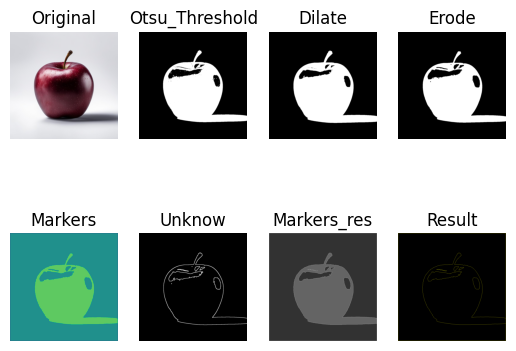

In [12]:
# тесты водораздела

import numpy as np
import cv2
from matplotlib import pyplot as plt


path = f'C:\\Users\\iraor\\images\\apple\\'
for i in range(1):
    img_name = f'image{i}' # image{i}
    image = cv2.imread(f'{path}\\original\\{img_name}.jpg')

    # print(type(image[0][0][0]))
    
    src = image
    img = src.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Устранение шума
    kernel = np.ones((2, 2), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    # Устранение дырок
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Расширение
    sure_bg = cv2.dilate(closing, kernel, iterations=3)
    
    # Преобразование расстояния
    sure_fg = cv2.erode(closing, kernel, iterations=3)
    
    # Получить неизвестную область
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Отметка
    ret, markers1 = cv2.connectedComponents(sure_fg)
   
    
    # Убедитесь, что фон равен 1, а не 0
    markers2 = markers1 + 1
    
    # Неизвестная область отмечена как 0
    markers2[unknown == 255] = 0

    cont = np.zeros(image.shape)
   
    
    markers3 = cv2.watershed(img, markers2)
    mar = markers3.reshape(1024*1024)
    
    max_i = max(mar)

    im_color = img

    for k in range(max_i+1):
        im_color[markers3 == k] = k*50

    im_color[markers3 == -1] = 255
        
    
    # im_color = cv2.applyColorMap(im_color.astype('uint8')) #, cv2.COLORMAP_JET)
    write_img(path, img_name, 'markers3', im_color)
    
    cont[markers3 == -1] = [255, 255, 0]
    
    plt.subplot(241), plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB)),
    plt.title('Original'), plt.axis('off')
    
    plt.subplot(242), plt.imshow(thresh, cmap='gray'),
    plt.title('Otsu_Threshold'), plt.axis('off')
    
    plt.subplot(243), plt.imshow(sure_bg, cmap='gray'),
    plt.title('Dilate'), plt.axis('off')
    
    plt.subplot(244), plt.imshow(sure_fg, cmap='gray'),
    plt.title('Erode'), plt.axis('off')

    plt.subplot(245), plt.imshow(markers2),
    plt.title('Markers'), plt.axis('off')
    
    plt.subplot(246), plt.imshow(unknown, cmap='gray'),
    plt.title('Unknow'), plt.axis('off')
    
    plt.subplot(247), plt.imshow(im_color),
    plt.title('Markers_res'), plt.axis('off')
    
    plt.subplot(248), plt.imshow(cont.astype('uint8')),
    plt.title('Result'), plt.axis('off')
    
    plt.show()

    





In [15]:
path = f'C:\\Users\\iraor\\images\\apple\\'
for i in range(100):
    img_name = f'image{i}' # image{i}
    image = cv2.imread(f'{path}\\original\\{img_name}.jpg')

# ---------------------------------------------------------------------------------------
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh_image, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    maxL=0
    sel_countour=None
    for countour in contours:
        if countour.shape[0]>maxL:
            sel_countour=countour
            maxL=countour.shape[0]
    
    
    x,y,w,h = cv2.boundingRect(sel_countour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (255,0,0), 8)
    return image


    # if not(os.path.exists(f'{path}_box')):
    #     os.makedirs(f'{path}_box')
    
    # cv2.imwrite(f'{path}_box\\image{i}.jpg', image)    
    




In [34]:
def correction(
        img,
        shadow_amount_percent, shadow_tone_percent, shadow_radius,
        highlight_amount_percent, highlight_tone_percent, highlight_radius,
        color_percent
):
    """
    Image Shadow / Highlight Correction. The same function as it in Photoshop / GIMP
    :param img: input RGB image numpy array of shape (height, width, 3)
    :param shadow_amount_percent [0.0 ~ 1.0]: Controls (separately for the highlight and shadow values in the image) how much of a correction to make.
    :param shadow_tone_percent [0.0 ~ 1.0]: Controls the range of tones in the shadows or highlights that are modified.
    :param shadow_radius [>0]: Controls the size of the local neighborhood around each pixel
    :param highlight_amount_percent [0.0 ~ 1.0]: Controls (separately for the highlight and shadow values in the image) how much of a correction to make.
    :param highlight_tone_percent [0.0 ~ 1.0]: Controls the range of tones in the shadows or highlights that are modified.
    :param highlight_radius [>0]: Controls the size of the local neighborhood around each pixel
    :param color_percent [-1.0 ~ 1.0]:
    :return:
    """
    shadow_tone = shadow_tone_percent * 255
    highlight_tone = 255 - highlight_tone_percent * 255

    shadow_gain = 1 + shadow_amount_percent * 6
    highlight_gain = 1 + highlight_amount_percent * 6

    # extract RGB channel
    height, width = img.shape[:2]
    img = img.astype(np.float64)
    img_R, img_G, img_B = img[..., 2].reshape(-1), img[..., 1].reshape(-1), img[..., 0].reshape(-1)

    # The entire correction process is carried out in YUV space,
    # adjust highlights/shadows in Y space, and adjust colors in UV space
    # convert to Y channel (grey intensity) and UV channel (color)
    img_Y = .3 * img_R + .59 * img_G + .11 * img_B
    img_U = -img_R * .168736 - img_G * .331264 + img_B * .5
    img_V = img_R * .5 - img_G * .418688 - img_B * .081312

    # extract shadow / highlight
    shadow_map = 255 - img_Y * 255 / shadow_tone
    shadow_map[np.where(img_Y >= shadow_tone)] = 0
    highlight_map = 255 - (255 - img_Y) * 255 / (255 - highlight_tone)
    highlight_map[np.where(img_Y <= highlight_tone)] = 0

    # // Gaussian blur on tone map, for smoother transition
    if shadow_amount_percent * shadow_radius > 0:
        # shadow_map = cv2.GaussianBlur(shadow_map.reshape(height, width), ksize=(shadow_radius, shadow_radius), sigmaX=0).reshape(-1)
        shadow_map = cv2.blur(shadow_map.reshape(height, width), ksize=(shadow_radius, shadow_radius)).reshape(-1)

    if highlight_amount_percent * highlight_radius > 0:
        # highlight_map = cv2.GaussianBlur(highlight_map.reshape(height, width), ksize=(highlight_radius, highlight_radius), sigmaX=0).reshape(-1)
        highlight_map = cv2.blur(highlight_map.reshape(height, width), ksize=(highlight_radius, highlight_radius)).reshape(-1)

    # Tone LUT
    t = np.arange(256)
    LUT_shadow = (1 - np.power(1 - t * (1 / 255), shadow_gain)) * 255
    LUT_shadow = np.maximum(0, np.minimum(255, np.int_(LUT_shadow + .5)))
    LUT_highlight = np.power(t * (1 / 255), highlight_gain) * 255
    LUT_highlight = np.maximum(0, np.minimum(255, np.int_(LUT_highlight + .5)))

    # adjust tone
    shadow_map = shadow_map * (1 / 255)
    highlight_map = highlight_map * (1 / 255)

    iH = (1 - shadow_map) * img_Y + shadow_map * LUT_shadow[np.int_(img_Y)]
    iH = (1 - highlight_map) * iH + highlight_map * LUT_highlight[np.int_(iH)]
    img_Y = iH

    # adjust color
    if color_percent != 0:
        # color LUT
        if color_percent > 0:
            LUT = (1 - np.sqrt(np.arange(32768)) * (1 / 128)) * color_percent + 1
        else:
            LUT = np.sqrt(np.arange(32768)) * (1 / 128) * color_percent + 1

        # adjust color saturation adaptively according to highlights/shadows
        color_gain = LUT[np.int_(img_U ** 2 + img_V ** 2 + .5)]
        w = 1 - np.minimum(2 - (shadow_map + highlight_map), 1)
        img_U = w * img_U + (1 - w) * img_U * color_gain
        img_V = w * img_V + (1 - w) * img_V * color_gain

    # re convert to RGB channel
    output_R = np.int_(img_Y + 1.402 * img_V + .5)
    output_G = np.int_(img_Y - .34414 * img_U - .71414 * img_V + .5)
    output_B = np.int_(img_Y + 1.772 * img_U + .5)

    output = np.row_stack([output_B, output_G, output_R]).T.reshape(height, width, 3)
    output = np.minimum(output, 255).astype(np.uint8)
    return output

image = cv2.imread('image37.jpg')

res = correction(rgb_image, 0.7, 0.7, 2, 0.7, 0.7, 2, 0.7)
cv2.imwrite('res.jpg', res)


True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO
from PIL import Image

import tensorflow as tf
from tensorflow import keras


upl = files.upload()
img = Image.open(BytesIO(upl['img.jpg']))
img_style = Image.open(BytesIO(upl['img_style.jpg']))

plt.subplot(1, 2, 1)
plt.imshow( img )
plt.subplot(1, 2, 2)
plt.imshow( img_style )
plt.show()

x_img = keras.applications.vgg19.preprocess_input( np.expand_dims(img, axis=0) )
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0))

def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False 

# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

print(vgg.input)
for m in model_outputs:
  print(m)

model = keras.models.Model(vgg.input, model_outputs)
for layer in model.layers:
    layer.trainable = False

print(model.summary())      # вывод структуры НС в консоль

def get_feature_representations(model):
  # batch compute content and style features
  style_outputs = model(x_style)
  content_outputs = model(x_img)
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

num_iterations=100
content_weight=1e3
style_weight=1e-2

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

for i in range(num_iterations):
    with tf.GradientTape() as tape: 
       all_loss = compute_loss(**cfg)
    
    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image)

    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

      # Use the .numpy() method to get the concrete numpy array
      plot_img = deprocess_img(init_image.numpy())
      imgs.append(plot_img)
      print('Iteration: {}'.format(i))

plt.imshow(best_img)
print(best_loss)

image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save("result.jpg")
files.download("result.jpg")

ModuleNotFoundError: No module named 'google'

## ВЫРЕЗАЕМ кусочки

In [12]:
# def rotation(img):
#     (h, w) = img.shape[:2]
#     center = (int(w / 2), int(h / 2))
#     rotation_matrix = cv2.getRotationMatrix2D(center, -45, 1)
#     rotated = cv2.warpAffine(img, rotation_matrix, (w, h))
#     return rotated

k = random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n = random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Load two images
img1 = cv2.imread('image13.jpg')
# cv2.imshow('img1',img1)

img2 = cv2.imread('im0.jpg')
# cv2.imshow('img2',img2)
img2 = cv2.resize(img2, None, fx=0.1*k+0.01, fy=0.1*k+0.01)


# mask= cv2.imread('image0.jpg', 0)
# mask = cv2.resize(mask, None, fx=0.1*k+0.01, fy=0.1*k+0.01)

# # mask = cv2.GaussianBlur(mask,(7,7),0)

wsh_mask, maskCont = watershed_img(img2)

thresh_image = wsh_mask
thresh_image[wsh_mask == 0] = 0
thresh_image[wsh_mask != 0] = 255
thresh_image = thresh_image.astype('uint8')
mask = thresh_image
# print(mask.dtype)
cv2.imshow('mask',mask)


rows,cols,channels = img2.shape
roi = img1[k*n:rows+k*n, k*n:cols+k*n]



mask_inv = cv2.bitwise_not(mask)
# cv2.imshow('mask_inv',mask_inv)

img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
# cv2.imshow('img1_bg',img1_bg)

img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
cv2.imshow('img2_fg',img2_fg)

dst = cv2.add(img1_bg,img2_fg)
# cv2.imshow('dst',dst)


img1[k*n:rows+k*n, k*n:cols+k*n] = dst
cv2.imshow('res',img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'


In [8]:
img1 = cv2.imread("C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/_wsh_mask/image1.jpg")
print(img1.dtype)

# for i in range(1024):
#     for j in range(1024):
#         if list(img1[i,j]) > [128, 128, 128]:
#             img1[i,j] = [0, 0, 0]
#         else:
#             img1[i,j] = [0, 255, 255]


# cv2.imshow('res',img1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

uint8


## Цвет маски

In [11]:
def watershed_img(image, mcolor):
    src = image
    img = src.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # Устранение дырок
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=15)
    # Расширение
    sure_bg = cv2.dilate(closing, kernel, iterations=5)
    # Преобразование расстояния
    sure_fg = cv2.erode(closing, kernel, iterations=5)
    # Получить неизвестную область
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)
    # Отметка
    ret, markers1 = cv2.connectedComponents(sure_fg)
    # Убедитесь, что фон равен 1, а не 0
    markers2 = markers1 + 1
    # Неизвестная область отмечена как 0
    markers2[unknown == 255] = 0
    # cont = np.zeros(image.shape)
    markers = cv2.watershed(img, markers2)
    labels = np.unique(markers) 
      
    coins = [] 
    for label in labels[2:]:    
        target = np.where(markers == label, 255, 0).astype(np.uint8) 
        contours, hierarchy = cv2.findContours( 
            target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE 
        ) 
        coins.append(contours[0]) 
    
    cont = img
    cont[0:1023, 0:1023] = [0,0,0]
    
    cv2.drawContours(cont, coins, -1, color=mcolor, thickness=-2) 
    return cont, coins


def bound_box_watershed(image, mcolor):
    wsh_mask = watershed_img(image, (255, 255, 255))

    thresh_image = otsu_threshold(wsh_mask)
    contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    maxl = 0
    sel_countour = None
    for countour in contours:
        if countour.shape[0] > maxl:
            sel_countour = countour
            maxl = countour.shape[0]
    x, y, w, h = cv2.boundingRect(sel_countour)
    cv2.rectangle(image, (x, y), (x + w, y + h), mcolor, 8)
    return image

img1 = cv2.imread("C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/original/image28.jpg")
mcolor = (90, 60, 90)
markers = bound_box_watershed(img1, mcolor)

cv2.imshow('markers',markers)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [4]:
import cv2
import numpy as np
def kmeans_img(image, mcolor):
    z = image.reshape((-1, 3))
    # convert to np.float32
    z = np.float32(z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k = 8
    ret, label, center = cv2.kmeans(z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape(image.shape)
    return res2

    # pix = list(res2[0,0])
    # img = res2
    # for i in range(res2.shape[0]):
    #     for j in range(res2.shape[1]):
    #         if list(res2[i,j]) == pix: 
    #             img[i,j] = [0,0,0]
    #         else: 
    #             img[i,j] = list(mcolor)
    # return img

def bound_box_kmeans(image, mcolor):
    
    kmeans = kmeans_img(image, (255, 255, 255))

    contours, hierarchy = cv2.findContours(grey_img(kmeans), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    maxl = 0
    sel_countour = None
    for countour in contours:
        if countour.shape[0] > maxl:
            sel_countour = countour
            maxl = countour.shape[0]
    x, y, w, h = cv2.boundingRect(sel_countour)
    cv2.rectangle(image, (x, y), (x + w, y + h), mcolor, 8)
    return image




img1 = cv2.imread("apple.png")
mcolor = (255, 0, 255)
km = kmeans_img(img1, mcolor)

cv2.imshow('km',km)

# box = bound_box_kmeans(img1, mcolor)

# cv2.imshow('box',box)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
def grey_img(image):
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return img_grey


def otsu_threshold(image, mcolor):
    grey_image = grey_img(image)
    ret, otsu = cv2.threshold(grey_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    mask = image.copy()
    mask[0:1024, 0:1024] = [0,0,0]

    for i in range(otsu.shape[0]):
        for j in range(otsu.shape[1]):
            if otsu[i,j] != 0:
                mask[i,j] = list(mcolor) 
    return mask

def bound_box_otsu(image, mcolor):
    thresh_image = otsu_threshold(image, (255, 255, 255))
    thresh_image = grey_img(thresh_image)

    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh_image, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    maxl = 0
    sel_contour = None
    for contour in contours:
        if contour.shape[0] > maxl:
            sel_contour = contour
            maxl = contour.shape[0]

    x, y, w, h = cv2.boundingRect(sel_contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), mcolor, 8)
    return image




img1 = cv2.imread("C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/original/image28.jpg")
mcolor = (255, 133, 121)
otsu = otsu_threshold(img1, mcolor)
# box = bound_box_otsu(img1, mcolor)

image = otsu

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if (list(image[i,j]) != list(mcolor)) and (list(image[i,j]) != [0,0,0]):
            print(image[i,j])
    



cv2.imshow('otsu', otsu)
# cv2.imshow('box', box)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
image = cv2.imread("C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/_otsu/image35.png")
mcolor = [99, 6, 212]
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if (list(image[i,j]) != list(mcolor)) and (list(image[i,j]) != [0,0,0]):
            print(image[i,j])

cv2.imshow('image', image)
# cv2.imshow('box', box)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [70]:
dead_files = []
alive_files = []

for i in range(3333):
    f = f"C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/original/image{i}.png"
    if not(os.path.exists(f)):
        # print(f"не хватает image{i}")
        dead_files.append(i)
    else: 
        # print(f"есть image{i}")
        alive_files.append(i)
print(dead_files)

[2951, 2957]


In [94]:
dead_files = []
alive_files = []

for i in range(3700):
    f = f"C:/Users/iraor/images/backgrounds/image{i}.png"
    if not(os.path.exists(f)):
        # print(f"не хватает image{i}")
        dead_files.append(i)
    else: 
        # print(f"есть image{i}")
        alive_files.append(i)

print(dead_files)

[]


In [1]:
import cv2


for i in range(1, 101):
    image = cv2.imread(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/skeletons/mask/image{i}.png")
    for k in range(image.shape[0]):
        for l in range(image.shape[0]):
            if (list(image[k, l]) == [1, 1, 1]):
                image[k, l] = [255, 241, 189]
    cv2.imwrite(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/skeletons/mask_color/image{i}.png", image)

In [22]:
import os
for i in range(1, 101):
    if os.path.exists(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/skeletons/mask/{i}.png"):
        os.rename(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/skeletons/mask/{i}.png", 
              f"C:/Users/iraor/PycharmProjects/FusionBrainGen/skeletons/mask/image{i}.png")





In [23]:
for i in range(1, 101):
    image = cv2.imread(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/skeletons/original/image{i}.png")
    image = cv2.resize(image, [512, 512], cv2.INTER_AREA)
    cv2.imwrite(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/skeletons/original/image{i}.png", image)

## Удаление теней

In [14]:
import cv2
import numpy as np

img = cv2.imread("C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/original/image3.jpg", -1)

rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((5,5), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 11)
    diff_img = 225 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)
    
result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

cv2.imwrite('shadows_out.png', result)
cv2.imwrite('shadows_out_norm.png', result_norm)

True

In [23]:
import cv2
import numpy as np


def change_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

img = cv2.imread("C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/original/image3.jpg")
res1 = change_brightness(img, value=255)
res1 = cv2.medianBlur(res1, 21)
res1 = cv2.dilate(res1, np.ones((21,21), np.uint8))

cv2.imwrite('res1.png', res1)


res2 = change_brightness(img, value=-200)
res2 = cv2.medianBlur(res2, 21)
res2 = cv2.dilate(res2, np.ones((21,21), np.uint8))

cv2.imwrite('res2.png', res2)


dst1 = cv2.addWeighted(res1,0.5,img,0.5,0)
cv2.imwrite('dst1.png', dst1)
dst2 = cv2.addWeighted(res2,0.9,img,0.1,0)
cv2.imwrite('dst2.png', dst2)
dst = cv2.addWeighted(dst1,0.5,dst2,0.9,0)

cv2.imwrite('dst.png', dst)


ots = otsu_threshold(res1)
cv2.imwrite('ots.png', ots)

result = cv2.inpaint(img, ots, 21, cv2.INPAINT_TELEA) 
cv2.imwrite('result.png', result)

True

In [49]:

img = dst
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, threshold = cv2.threshold(img, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2.imwrite('threshold.png', threshold)

True

In [7]:
import cv2
import numpy as np

img = cv2.imread("C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/original/image3.jpg")
src = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
equalize = cv2.equalizeHist(src)
equalize = cv2.equalizeHist(equalize)
cv2.imwrite('equalize.png', equalize)

True

In [27]:
import cv2
import numpy as np

img = cv2.imread("C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/original/image3.jpg")

def shadow_remove(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadowremov = cv2.merge(result_norm_planes)
    return shadowremov
#Shadow removal
shad = shadow_remove(img)
cv2.imwrite('after_shadow_remove1.jpg', shad)

True

In [31]:
def change_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

img = cv2.imread("C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/original/image3.jpg")
sum = cv2.addWeighted(shad,0.9,img,0.7,1)
cv2.imwrite('sum.jpg', sum)
br_low = change_brightness(sum, value=-50)
cv2.imwrite('br_low.jpg', br_low)

th = otsu_threshold(br_low)
cv2.imwrite('th.jpg', th)


cv2.imwrite('equalize_sum.png', equalize_sum)

True

In [ ]:
import numpy as np
import cv2

# read an image with shadow...
# and it converts to BGR color space automatically
or_img = cv2.imread("C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/original/image3.jpg")

# covert the BGR image to an YCbCr image
y_cb_cr_img = cv2.cvtColor(or_img, cv2.COLOR_BGR2YCrCb)

# copy the image to create a binary mask later
binary_mask = np.copy(y_cb_cr_img)

# get mean value of the pixels in Y plane
y_mean = np.mean(cv2.split(y_cb_cr_img)[0])

# get standard deviation of channel in Y plane
y_std = np.std(cv2.split(y_cb_cr_img)[0])

# classify pixels as shadow and non-shadow pixels
for i in range(y_cb_cr_img.shape[0]):
    for j in range(y_cb_cr_img.shape[1]):

        if y_cb_cr_img[i, j, 0] < y_mean - (y_std / 3):
            # paint it white (shadow)
            binary_mask[i, j] = [255, 255, 255]
        else:
            # paint it black (non-shadow)
            binary_mask[i, j] = [0, 0, 0]

# Using morphological operation
# The misclassified pixels are
# removed using dilation followed by erosion.
kernel = np.ones((3, 3), np.uint8)
erosion = cv2.erode(binary_mask, kernel, iterations=1)

# sum of pixel intensities in the lit areas
spi_la = 0

# sum of pixel intensities in the shadow
spi_s = 0

# number of pixels in the lit areas
n_la = 0

# number of pixels in the shadow
n_s = 0

# get sum of pixel intensities in the lit areas
# and sum of pixel intensities in the shadow
for i in range(y_cb_cr_img.shape[0]):
    for j in range(y_cb_cr_img.shape[1]):
        if erosion[i, j, 0] == 0 and erosion[i, j, 1] == 0 and erosion[i, j, 2] == 0:
            spi_la = spi_la + y_cb_cr_img[i, j, 0]
            n_la += 1
        else:
            spi_s = spi_s + y_cb_cr_img[i, j, 0]
            n_s += 1

# get the average pixel intensities in the lit areas
average_ld = spi_la / n_la

# get the average pixel intensities in the shadow
average_le = spi_s / n_s

# difference of the pixel intensities in the shadow and lit areas
i_diff = average_ld - average_le

# get the ratio between average shadow pixels and average lit pixels
ratio_as_al = average_ld / average_le

# added these difference
for i in range(y_cb_cr_img.shape[0]):
    for j in range(y_cb_cr_img.shape[1]):
        if erosion[i, j, 0] == 255 and erosion[i, j, 1] == 255 and erosion[i, j, 2] == 255:

            y_cb_cr_img[i, j] = [y_cb_cr_img[i, j, 0] + i_diff, y_cb_cr_img[i, j, 1] + ratio_as_al,
                                 y_cb_cr_img[i, j, 2] + ratio_as_al]

# covert the YCbCr image to the BGR image
final_image = cv2.cvtColor(y_cb_cr_img, cv2.COLOR_YCR_CB2BGR)

cv2.imshow("im1", or_img)
cv2.imshow("im2", final_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## CUT and PASTE

In [111]:
for i in range(3700):
    img = cv2.imread(f"C:/Users/iraor/images/backgrounds/image{i}.png")
    img2 = cv2.resize(img, [512, 512], cv2.INTER_AREA)
    cv2.imwrite(f"C:/Users/iraor/images/backgrounds/image{i}.png", img2)

In [41]:


def grey_img(image):
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return img_grey
    
def otsu_threshold(image, mcolor):
    grey_image = grey_img(image)
    ret, otsu = cv2.threshold(grey_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    mask = image.copy()
    mask[0:image.shape[0], 0:image.shape[0]] = [0, 0, 0]

    for i in range(otsu.shape[0]):
        for j in range(otsu.shape[1]):
            if otsu[i, j] != 0:
                mask[i, j] = list(mcolor)
    return mask

# def img_backs(i):
    


for i in range(16):
    # thread = threading.Thread(target=img_backs, args=(i))
    # thread.start()
    num = random.choice(np.arange(3700))
    
    
    k = 0 # random.choice(np.arange(256))
    n = 0 # random.choice(np.arange(256))
    
    img1 = cv2.imread(f"C:/Users/iraor/images/backgrounds/image{num}.png")
    img2 = cv2.imread(f"C:/Users/iraor/apples_dataset2/img_test/image{i}.png")
    
    # img2 = cv2.resize(img2, [256, 256], cv2.INTER_AREA) # рандомизировать размер
    
    rows,cols,channels = img2.shape
    roi = img1[k:rows+k, n:cols+n]
    mask = otsu_threshold(img2, [255, 255, 255]) # алгоритм выделения маски
    mask = grey_img(mask)
    
    mask_inv = cv2.bitwise_not(mask)
    img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    dst = cv2.add(img1_bg,img2_fg)
    img1[k:rows+k, n:cols+n] = dst

    cv2.imwrite(f"C:/Users/iraor/apples_backs/image{i}.png", img1)
    
   

# cv2.imshow('res',img1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [38]:

def grey_img(image):
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return img_grey
    
def watershed_img(image, mcolor):
    src = image
    img = src.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # Устранение дырок
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=15)
    # Расширение
    sure_bg = cv2.dilate(closing, kernel, iterations=5)
    # Преобразование расстояния
    sure_fg = cv2.erode(closing, kernel, iterations=5)
    # Получить неизвестную область
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)
    # Отметка
    ret, markers1 = cv2.connectedComponents(sure_fg)
    # Убедитесь, что фон равен 1, а не 0
    markers2 = markers1 + 1
    # Неизвестная область отмечена как 0
    markers2[unknown == 255] = 0
    # cont = np.zeros(image.shape)
    markers = cv2.watershed(img, markers2)
    labels = np.unique(markers)

    coins = []
    for label in labels[2:]:
        target = np.where(markers == label, 255, 0).astype(np.uint8)
        contours, hierarchy = cv2.findContours(
            target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        coins.append(contours[0])
    cont = img
    cont[0:image.shape[0], 0:image.shape[0]] = [0, 0, 0]
    cv2.drawContours(cont, coins, -1, color=mcolor, thickness=-2)
    return cont

for i in range(150):
    img = cv2.imread(f"C:/Users/iraor/images/apple/negative/image{i}.png")
    otsu = watershed_img(img, [212, 6, 99])
    cv2.imwrite(f"C:/Users/iraor/images/apple/watershed/image{i}.png", otsu)
    
    


In [73]:
dead_files = []
alive_files = []

for i in range(1000):
    f = f"C:/Users/iraor/PycharmProjects/FusionBrainGen/images/apple/original/image{i}.png"
    if not(os.path.exists(f)):
        # print(f"не хватает image{i}")
        dead_files.append(i)
    else: 
        # print(f"есть image{i}")
        alive_files.append(i)
print(dead_files)

[1697, 2196, 2222, 2829]


In [14]:
image = cv2.imread("C:/Users/iraor/cut_paste/apple.png")

for i in range(image.shape[0]):
    for j in range(image.shape[0]):
        image[i,j] = [0, 0, 0]
cv2.imwrite("C:/Users/iraor/cut_paste/back_mask.png", image)

True

In [75]:
def translate_text(text):
    translator = Translator()
    translated_ita = translator.translate(text, src='ru', dest='en')
    tr_obj = translated_ita.text
    return tr_obj

def grey_img(image):
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return img_grey
    
def otsu_threshold(image, mcolor):
    grey_image = grey_img(image)
    ret, otsu = cv2.threshold(grey_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    mask = image.copy()
    mask[0:image.shape[0], 0:image.shape[0]] = [0, 0, 0]

    for i in range(otsu.shape[0]):
        for j in range(otsu.shape[1]):
            if otsu[i, j] != 0:
                mask[i, j] = list(mcolor)
    return mask

def watershed_img(image, mcolor):
    src = image
    img = src.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # Устранение дырок
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=15)
    # Расширение
    sure_bg = cv2.dilate(closing, kernel, iterations=5)
    # Преобразование расстояния
    sure_fg = cv2.erode(closing, kernel, iterations=5)
    # Получить неизвестную область
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)
    # Отметка
    ret, markers1 = cv2.connectedComponents(sure_fg)
    # Убедитесь, что фон равен 1, а не 0
    markers2 = markers1 + 1
    # Неизвестная область отмечена как 0
    markers2[unknown == 255] = 0
    # cont = np.zeros(image.shape)
    markers = cv2.watershed(img, markers2)
    labels = np.unique(markers)

    coins = []
    for label in labels[2:]:
        target = np.where(markers == label, 255, 0).astype(np.uint8)
        contours, hierarchy = cv2.findContours(
            target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        coins.append(contours[0])
    cont = img
    cont[0:image.shape[0], 0:image.shape[0]] = [0, 0, 0]
    cv2.drawContours(cont, coins, -1, color=mcolor, thickness=-2)
    return cont


def kmeans_img(image, mcolor):
    z = image.reshape((-1, 3))
    # convert to np.float32
    z = np.float32(z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k = 2
    ret, label, center = cv2.kmeans(z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape(image.shape)

    pix = list(res2[0, image.shape[0]-1])
    img = res2
    for i in range(res2.shape[0]):
        for j in range(res2.shape[1]):
            if list(res2[i, j]) == pix:
                img[i, j] = [0, 0, 0]
            else:
                img[i, j] = list(mcolor)
    return img



def cut_paste(paste_img, back, back_mask, mcolor, mask_alg):
    # размер уменьшения объекта
    sizes = [128, 256, 512]
    size = random.choice(sizes)

    # смешение объекта верт.+гориз.
    if size == 512:
        k = 0
        n = 0
    else:
        k = random.choice(np.arange(size))
        n = random.choice(np.arange(size))

    # меняем размер объекта
    paste_img = cv2.resize(paste_img, [size, size], cv2.INTER_AREA)

    rows, cols, channels = paste_img.shape
    roi = back[k:rows + k, n:cols + n]

    if mask_alg == "otsu":
        mask = otsu_threshold(paste_img, [255, 255, 255])
        color_mask = otsu_threshold(paste_img, mcolor)
    elif mask_alg == "kmeans":
        mask = kmeans_img(paste_img, [255, 255, 255])
        color_mask = kmeans_img(paste_img, mcolor)
    elif mask_alg == "watershed":
        mask = watershed_img(paste_img, [255, 255, 255])
        color_mask = watershed_img(paste_img, mcolor)
    

    mask = grey_img(mask)

    mask_inv = cv2.bitwise_not(mask)
    img1_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
    img2_fg = cv2.bitwise_and(paste_img, paste_img, mask=mask)
    dst = cv2.add(img1_bg, img2_fg)
    back[k:rows + k, n:cols + n] = dst

    roi = back_mask[k:rows + k, n:cols + n]
    img1_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
    img2_fg = cv2.bitwise_and(color_mask, color_mask, mask=mask)
    dst = cv2.add(img1_bg, img2_fg)
    back_mask[k:rows + k, n:cols + n] = dst
    return back, back_mask


def cut_paste_th(img_count, classes, colormap, i, prev, prev_mask, mask_alg):
    for num in range(len(classes)):
        # "C:/Users/iraor/PycharmProjects/FusionBrainGen/images/{translate_text(classes[num])}/original/"
        img = cv2.imread(
            f"C:/Users/iraor/PycharmProjects/FusionBrainGen/images/{classes[num]}/original/image{random.choice(np.arange(img_count))}.png")
        one_class, one_class_mask = cut_paste(img, prev, prev_mask, colormap[num], mask_alg)
        prev = one_class
        prev_mask = one_class_mask

    cv2.imwrite(f"join_classes/original/image{i}", prev)
    cv2.imwrite(f"join_classes/mask/image{i}", prev_mask)


img_count = 3333
classes = ["яблоко", "цветок"]
colormap = [[1, 1, 1], [2, 2, 2]]

for i in range(img_count):
    back = cv2.imread("C:/Users/iraor/cut_paste/back.png")
    back_mask = cv2.imread("C:/Users/iraor/cut_paste/back_mask.png")
    
    prev = back
    prev_mask = back_mask

    thread = threading.Thread(target=cut_paste_th, args=(img_count, classes, colormap, i, prev, prev_mask, mask_alg))
    thread.start()
   
    
   


In [83]:
for i in range(9):
    img = cv2.imread(f"C:/Users/iraor/apples_flowers2/mask_true/image{i}.png")
    img_res = cv2.resize(img, [512, 512], cv2.INTER_AREA)
    cv2.imwrite(f"C:/Users/iraor/apples_flowers2/mask_true/image{i}.png", img_res)

In [81]:
for i in range(9):
    back = cv2.imread("C:/Users/iraor/apples_flowers2/img_test/back.png")
    back_mt = cv2.imread("C:/Users/iraor/apples_flowers2/mask_true/back_mt.png")

    img1 = cv2.imread(f"C:/Users/iraor/apples_flowers2/img_test/image{i}.png")
    img2 = cv2.imread(f"C:/Users/iraor/apples_flowers2/img_test/image{i+10}.png")
    img3 = cv2.imread(f"C:/Users/iraor/apples_flowers2/img_test/image{i+11}.png")
    img4 = cv2.imread(f"C:/Users/iraor/apples_flowers2/img_test/image{i+1}.png")

    img1_mt = cv2.imread(f"C:/Users/iraor/apples_flowers2/mask_true/image{i}.png")
    img2_mt = cv2.imread(f"C:/Users/iraor/apples_flowers2/mask_true/image{i+10}.png")
    img3_mt = cv2.imread(f"C:/Users/iraor/apples_flowers2/mask_true/image{i+11}.png")
    img4_mt = cv2.imread(f"C:/Users/iraor/apples_flowers2/mask_true/image{i+1}.png")

    back[0:512, 0:512] = img1
    back[512:1024, 0:512] = img2
    back[0:512, 512:1024] = img3
    back[512:1024, 512:1024] = img4

    back_mt[0:512, 0:512] = img1_mt
    back_mt[512:1024, 0:512] = img2_mt
    back_mt[0:512, 512:1024] = img3_mt
    back_mt[512:1024, 512:1024] = img4_mt
    
    cv2.imwrite(f"C:/Users/iraor/apples_flowers2/img_test/back{i}.png", back)
    cv2.imwrite(f"C:/Users/iraor/apples_flowers2/mask_true/back_mt{i}.png", back_mt)
















## Cut paste with bounding box


In [7]:
def grey_img(image):
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return img_grey


def otsu_threshold(image, mcolor):
    grey_image = grey_img(image)
    ret, otsu = cv2.threshold(grey_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    mask = image.copy()
    mask[0:image.shape[0], 0:image.shape[0]] = [0, 0, 0]

    for i in range(otsu.shape[0]):
        for j in range(otsu.shape[1]):
            if otsu[i, j] != 0:
                mask[i, j] = list(mcolor)
    return mask


def watershed_img(image, mcolor):
    src = image
    img = src.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # Устранение дырок
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=15)
    # Расширение
    sure_bg = cv2.dilate(closing, kernel, iterations=5)
    # Преобразование расстояния
    sure_fg = cv2.erode(closing, kernel, iterations=5)
    # Получить неизвестную область
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)
    # Отметка
    ret, markers1 = cv2.connectedComponents(sure_fg)
    # Убедитесь, что фон равен 1, а не 0
    markers2 = markers1 + 1
    # Неизвестная область отмечена как 0
    markers2[unknown == 255] = 0
    # cont = np.zeros(image.shape)
    markers = cv2.watershed(img, markers2)
    labels = np.unique(markers)

    coins = []
    for label in labels[2:]:
        target = np.where(markers == label, 255, 0).astype(np.uint8)
        contours, hierarchy = cv2.findContours(
            target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        coins.append(contours[0])
    cont = img
    cont[0:image.shape[0], 0:image.shape[0]] = [0, 0, 0]
    cv2.drawContours(cont, coins, -1, color=mcolor, thickness=-2)
    return cont


def kmeans_img(image, mcolor):
    z = image.reshape((-1, 3))
    # convert to np.float32
    z = np.float32(z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k = 2
    ret, label, center = cv2.kmeans(z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape(image.shape)

    pix = list(res2[0, image.shape[0]-1])
    img = res2
    for i in range(res2.shape[0]):
        for j in range(res2.shape[1]):
            if list(res2[i, j]) == pix:
                img[i, j] = [0, 0, 0]
            else:
                img[i, j] = list(mcolor)
    return img


def bound_box_otsu(image, mcolor):
    thresh_image = otsu_threshold(image, (255, 255, 255))
    thresh_image = grey_img(thresh_image)

    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh_image, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    maxl = 0
    sel_contour = None
    for contour in contours:
        if contour.shape[0] > maxl:
            sel_contour = contour
            maxl = contour.shape[0]

    x, y, w, h = cv2.boundingRect(sel_contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), mcolor, 8)
    return image, [x, y, w, h]


def bound_box_kmeans(image, mcolor):
    kmeans = kmeans_img(image, (255, 255, 255))

    contours, hierarchy = cv2.findContours(grey_img(kmeans), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    maxl = 0
    sel_countour = None
    for countour in contours:
        if countour.shape[0] > maxl:
            sel_countour = countour
            maxl = countour.shape[0]
    x, y, w, h = cv2.boundingRect(sel_countour)
    cv2.rectangle(image, (x, y), (x + w, y + h), mcolor, 8)
    return image, [x, y, w, h]


def bound_box_watershed(image, mcolor):
    wsh_mask = watershed_img(image, (255, 255, 255))

    thresh_image = grey_img(wsh_mask)
    contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    maxl = 0
    sel_countour = None
    for countour in contours:
        if countour.shape[0] > maxl:
            sel_countour = countour
            maxl = countour.shape[0]
    x, y, w, h = cv2.boundingRect(sel_countour)
    cv2.rectangle(image, (x, y), (x + w, y + h), mcolor, 8)
    return image, [x, y, w, h]

In [58]:
def cut_paste_box(paste_img, back, mcolor, mask_alg):
    # размер уменьшения объекта
    sizes = [128, 256, 512]
    size = random.choice(sizes)
    
    # смешение объекта верт.+гориз.
    if size == 512:
        k = 0
        n = 0
    else:
        k = random.choice(np.arange(size))
        n = random.choice(np.arange(size))

    # меняем размер объекта
    paste_img = cv2.resize(paste_img, [size, size], cv2.INTER_AREA)

    rows, cols, channels = paste_img.shape
    roi = back[k:rows + k, n:cols + n]

    paste_img_copy = paste_img.copy()

    if mask_alg == "otsu":
        mask = otsu_threshold(paste_img, [255, 255, 255])
        color_mask, bound_box = bound_box_otsu(paste_img, mcolor)
    elif mask_alg == "kmeans":
        mask = kmeans_img(paste_img, [255, 255, 255])
        color_mask, bound_box = bound_box_kmeans(paste_img, mcolor)
    elif mask_alg == "watershed":
        mask = watershed_img(paste_img, [255, 255, 255])
        color_mask, bound_box = bound_box_watershed(paste_img, mcolor)

    mask = grey_img(mask)
    mask_inv = cv2.bitwise_not(mask)
    img1_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
    img2_fg = cv2.bitwise_and(paste_img_copy, paste_img_copy, mask=mask)
    dst = cv2.add(img1_bg, img2_fg)
    back[k:rows + k, n:cols + n] = dst

    x1 = bound_box[0]+n
    y1 = bound_box[1]+k

    x2 = x1+bound_box[2]
    y2 = y1+bound_box[3]

    print(f"roi: {k, n, rows + k, cols + n}, box: {x1, y1, x2, y2}")
    
    return back, x1, y1, x2, y2


def box_cut_paste_th(img_count, classes, colormap, i, prev, mask_alg):
    bounding_boxes = []
    for num in range(len(classes)):
        # "C:/Users/iraor/PycharmProjects/FusionBrainGen/images/{translate_text(classes[num])}/original/"
        img_num = random.choice(np.arange(img_count))
        img = cv2.imread(
            f"C:/Users/iraor/PycharmProjects/FusionBrainGen/images/{classes[num]}/original/image{img_num}.png")
        print(f"image{img_num}")
        one_class, x1, y1, x2, y2 = cut_paste_box(img, prev, colormap[num], mask_alg)
        prev = one_class
        bounding_boxes.append([x1, y1, x2, y2])

    prev_mask = prev.copy()
    for num in range(len(classes)):
        x1, y1, x2, y2 = bounding_boxes[num]
        prev_mask = cv2.rectangle(prev_mask, (x1, y1), (x2, y2), colormap[num], 2)

    
    cv2.imwrite(f"join_classes/original/image{i}.png", prev)
    cv2.imwrite(f"join_classes/mask/image{i}.png", prev_mask)
    # print(x1, y1, x2, y2)


img_count = 10
classes = ["apple", "flower"]
colormap = [[99, 6, 212], [255, 133, 121]]

for i in range(img_count):
    back = cv2.imread("C:/Users/iraor/cut_paste/back.png")

    prev = back
    thread = threading.Thread(target=box_cut_paste_th, args=(img_count, classes, colormap, i, prev, "kmeans"))
    thread.start()

image9
image9
image9
image3
image0
roi: (99, 114, 227, 242), box: (133, 116, 213, 198)
roi: (40, 58, 168, 186), box: (60, 60, 166, 153)
image9
image7
image7
roi: (106, 71, 234, 199), box: (73, 126, 179, 219)image2
image0

roi: (38, 67, 166, 195), box: (106, 54, 171, 128)
image6
image4image6

image7
roi: (2, 53, 130, 181), box: (92, 18, 157, 92)
image0
roi: (55, 35, 183, 163), box: (58, 68, 148, 154)
image1
roi: (4, 249, 260, 505), box: (273, 16, 494, 238)
roi: (55, 41, 183, 169), box: (53, 61, 164, 172)
roi: (0, 0, 512, 512), box: (9, 79, 431, 454)
roi: (199, 233, 455, 489), box: (272, 265, 429, 407)
image9
roi: (0, 0, 512, 512), box: (9, 79, 431, 454)
image3
image5
roi: (117, 54, 245, 182), box: (62, 129, 168, 231)
roi: (0, 0, 512, 512), box: (59, 68, 476, 494)
roi: (114, 6, 242, 134), box: (39, 140, 124, 231)
roi: (85, 214, 341, 470), box: (214, 125, 430, 317)
roi: (0, 0, 512, 512), box: (110, 114, 434, 386)
roi: (0, 0, 512, 512), box: (59, 68, 476, 494)
image8
roi: (0, 0, 512, 512),

# Графики

In [128]:
CLASSES = [
    'фон',
    'яблоко',
    'цветок'
]

#---------------------------------------------------------------
otsu_train_loss = [0.1987, 0.0510, 0.0393, 0.0227,  0.0140]
otsu_train_accuracy = [0.9276, 0.9817, 0.9858, 0.9913, 0.9946]
otsu_train_MIoU = [0.7348, 0.9072, 0.9271, 0.9459, 0.9840]
otsu_train_pclIOU = [0.9970,  0.9519, 0.9730]

otsu_val_loss = [1.8587, 1.6974, 1.4158, 0.0246, 0.0198]
otsu_val_accuracy = [0.8619, 0.9224, 0.9765, 0.9855, 0.9933]
otsu_val_MIoU = [0.7538, 0.8713, 0.9332, 0.9856, 0.9888]
otsu_val_pclIOU = [0.9971,  0.9244, 0.9632]
#---------------------------------------------------------------
kmeans_train_loss = [0.1097, 0.0345, 0.0252, 0.0154, 0.0128]
kmeans_train_accuracy = [0.9622,  0.9884, 0.9911, 0.9944, 0.9956]
kmeans_train_MIoU = [0.8373, 0.9420, 0.9554, 0.9578, 0.9724]
kmeans_train_pclIOU = [0.9971, 0.9495, 0.9706]

kmeans_val_loss = [5.5810, 4.4188, 0.0252, 0.0244, 0.0117]
kmeans_val_accuracy = [0.2741, 0.3506, 0.9938, 0.9950, 0.9958]
kmeans_val_MIoU = [0.2406, 0.4627, 0.8710, 0.9778, 0.9808]
kmeans_val_pclIOU = [0.9974, 0.9679, 0.9772]
#---------------------------------------------------------------
watershed_train_loss = [0.1043,  0.0249, 0.0226, 0.0169, 0.0141]
watershed_train_accuracy = [0.9617, 0.9908, 0.9917, 0.9939, 0.9947]
watershed_train_MIoU = [0.8529, 0.9593, 0.9636, 0.9738, 0.9772]
watershed_train_pclIOU = [0.9973, 0.9698, 0.9646]

watershed_val_loss = [3.7495, 0.9675, 0.0581, 0.0398, 0.0186]
watershed_val_accuracy = [0.2839, 0.2925, 0.3785, 0.9859, 0.9889]
watershed_val_MIoU = [0.1864, 0.3134, 0.6039, 0.9329, 0.9646]
watershed_val_pclIOU = [0.9934,  0.9564, 0.9439]
#---------------------------------------------------------------


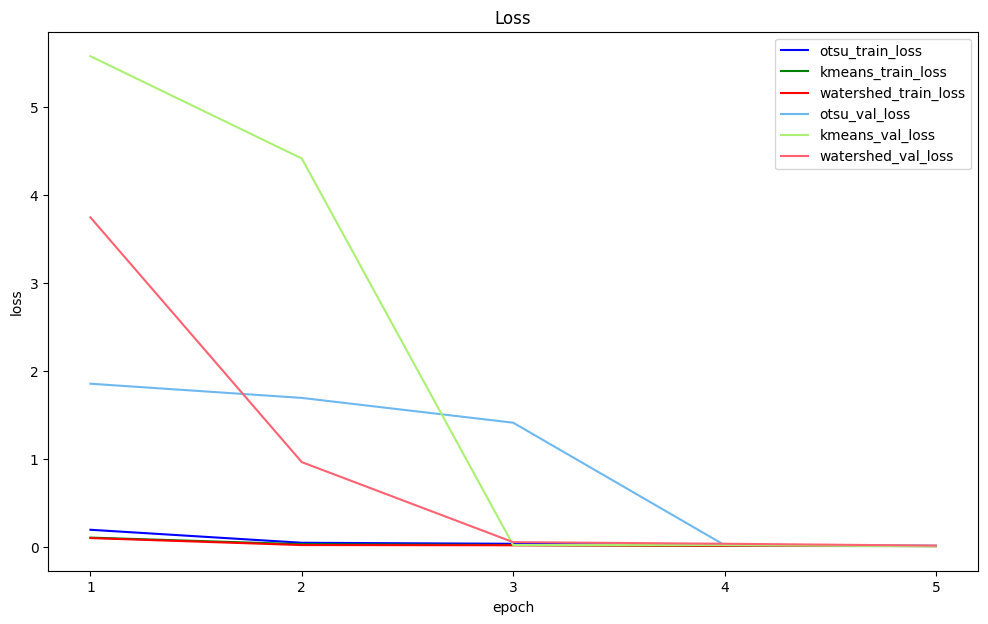

In [109]:
x = epochs = [1, 2, 3, 4, 5]
plt.figure(figsize = (12, 7))
plt.plot(epochs, otsu_train_loss,  label = 'otsu_train_loss', color = 'b')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, kmeans_train_loss, label = 'kmeans_train_loss', color = 'g')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, watershed_train_loss,  label = 'watershed_train_loss', color = 'r')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, otsu_val_loss,  label = 'otsu_val_loss', color = '#6eb8f0')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, kmeans_val_loss, label = 'kmeans_val_loss', color = '#abf073')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, watershed_val_loss,  label = 'watershed_val_loss', color = '#fc6272')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

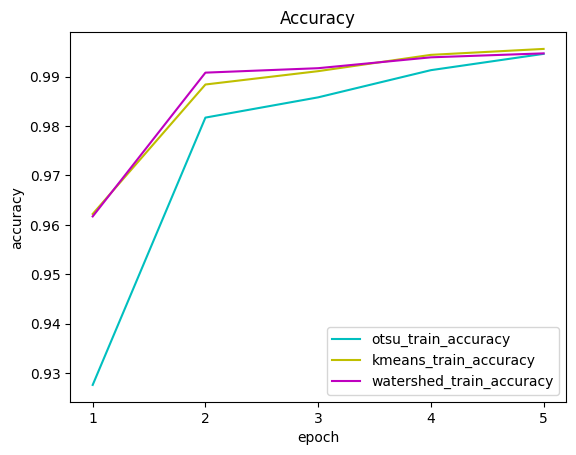

In [110]:
x = epochs = [1, 2, 3, 4, 5]
plt.plot(epochs, otsu_train_accuracy,  label = 'otsu_train_accuracy', color = 'c')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, kmeans_train_accuracy, label = 'kmeans_train_accuracy', color = 'y')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, watershed_train_accuracy,  label = 'watershed_train_accuracy', color = 'm')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

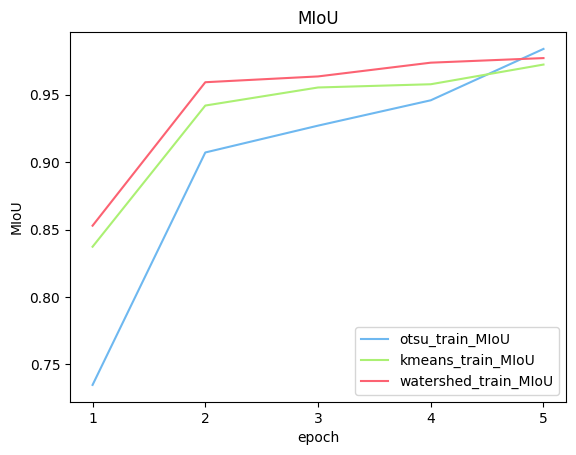

In [111]:
x = epochs = [1, 2, 3, 4, 5]
plt.plot(epochs, otsu_train_MIoU,  label = 'otsu_train_MIoU', color = '#6eb8f0')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, kmeans_train_MIoU, label = 'kmeans_train_MIoU', color = '#abf073')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, watershed_train_MIoU,  label = 'watershed_train_MIoU', color = '#fc6272')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.title("MIoU")
plt.ylabel("MIoU")
plt.xlabel("epoch")
plt.legend()
plt.show()

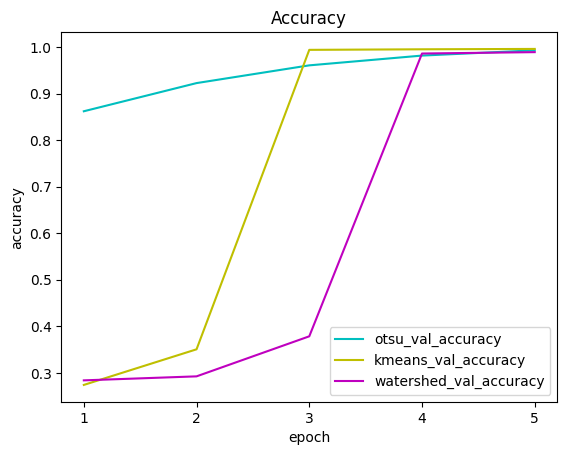

In [112]:
x = epochs = [1, 2, 3, 4, 5]
plt.plot(epochs, otsu_val_accuracy,  label = 'otsu_val_accuracy', color = 'c')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, kmeans_val_accuracy, label = 'kmeans_val_accuracy', color = 'y')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, watershed_val_accuracy,  label = 'watershed_val_accuracy', color = 'm')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

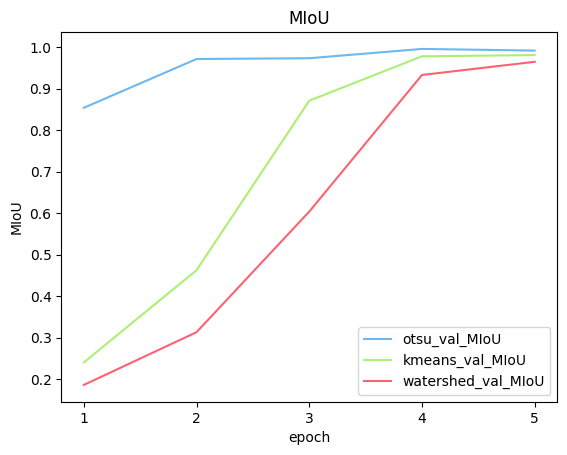

In [126]:
x = epochs = [1, 2, 3, 4, 5]
plt.plot(epochs, otsu_val_MIoU,  label = 'otsu_val_MIoU', color = '#6eb8f0')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, kmeans_val_MIoU, label = 'kmeans_val_MIoU', color = '#abf073')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.plot(epochs, watershed_val_MIoU,  label = 'watershed_val_MIoU', color = '#fc6272')
plt.xticks(np.arange(min(x), max(x)+1, 1.0)) 
plt.title("MIoU")
plt.ylabel("MIoU")
plt.xlabel("epoch")
plt.legend()
plt.show()

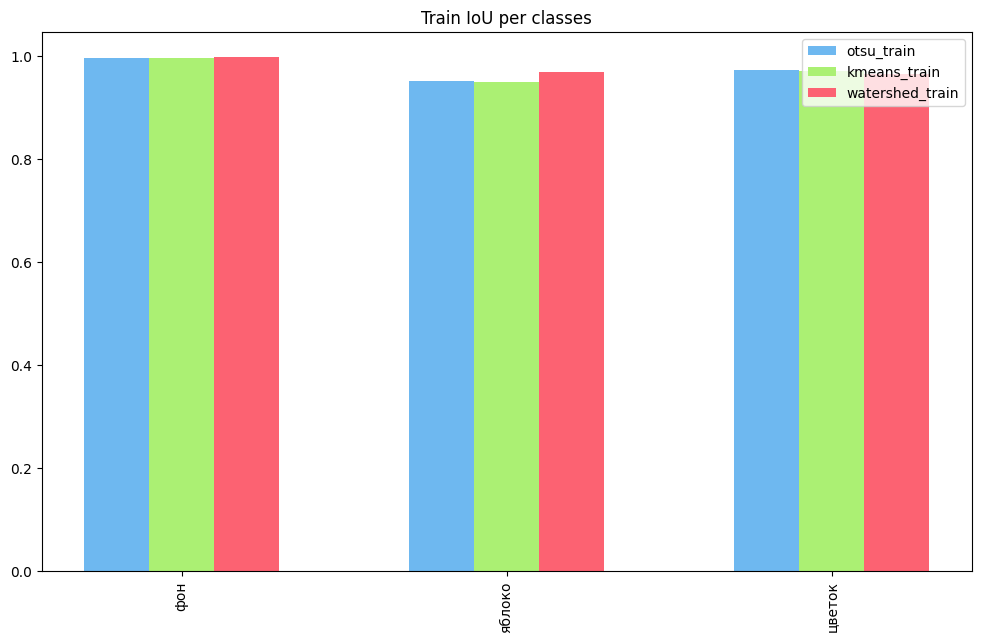

In [114]:
x_axis = np.arange(len(CLASSES))
plt.figure(figsize = (12, 7))
plt.title('Train IoU per classes')
plt.bar(x_axis-0.2, otsu_train_pclIOU, width=0.2, color='#6eb8f0', label='otsu_train')
plt.bar(x_axis, kmeans_train_pclIOU, width=0.2, color='#abf073', label='kmeans_train')
plt.bar(x_axis+0.2, watershed_train_pclIOU, width=0.2, color='#fc6272', label='watershed_train')
plt.xticks(x_axis, CLASSES, rotation=90)
plt.legend()
plt.show()

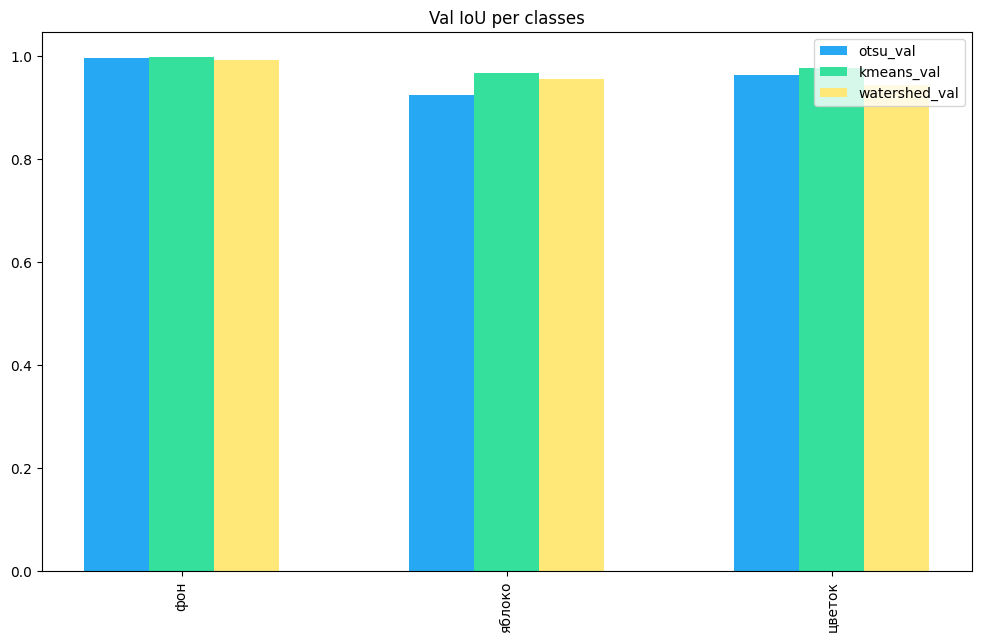

In [115]:
x_axis = np.arange(len(CLASSES))
plt.figure(figsize = (12, 7))
plt.title('Val IoU per classes')
plt.bar(x_axis-0.2, otsu_val_pclIOU, width=0.2, color='#27a8f2', label='otsu_val')
plt.bar(x_axis, kmeans_val_pclIOU, width=0.2, color='#34e09b', label='kmeans_val')
plt.bar(x_axis+0.2, watershed_val_pclIOU, width=0.2, color='#ffe878', label='watershed_val')
plt.xticks(x_axis, CLASSES, rotation=90)
plt.legend()
plt.show()

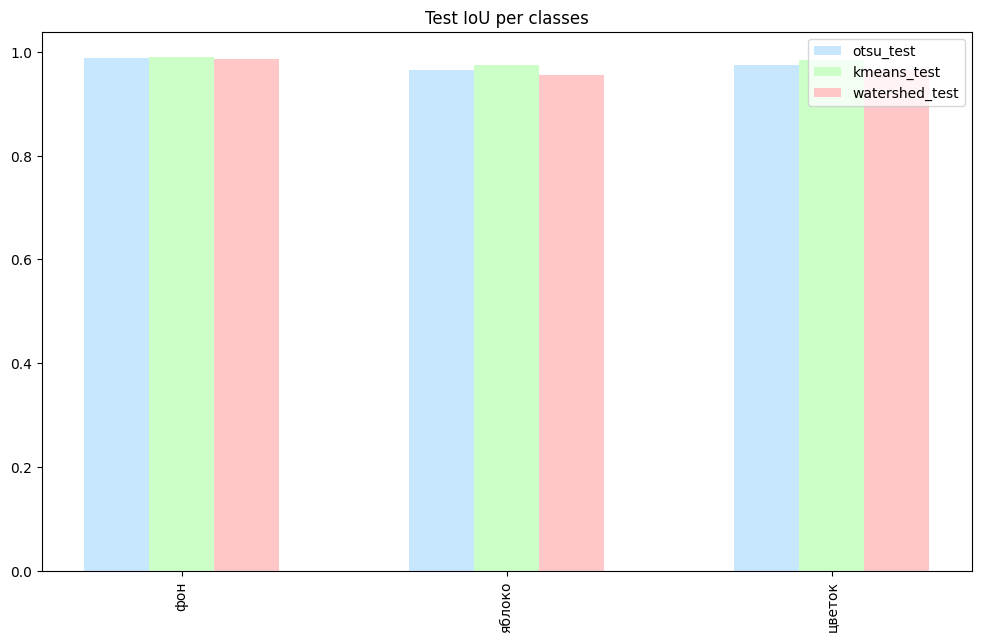

In [116]:
otsu_test_pclIOU = [0.9876477079864002, 0.9642739759344418, 0.974775551548837]
kmeans_test_pclIOU = [0.989, 0.9742739759344418, 0.984775551548837]
watershed_test_pclIOU = [0.986, 0.9542739759344418, 0.964775551548837]

x_axis = np.arange(len(CLASSES))
plt.figure(figsize = (12, 7))
plt.title('Test IoU per classes')
plt.bar(x_axis-0.2, otsu_test_pclIOU, width=0.2, color='#c7e7ff', label='otsu_test')
plt.bar(x_axis, kmeans_test_pclIOU, width=0.2, color='#cbffc7', label='kmeans_test')
plt.bar(x_axis+0.2, watershed_test_pclIOU, width=0.2, color='#ffc7c7', label='watershed_test')
plt.xticks(x_axis, CLASSES, rotation=90)
plt.legend()
plt.show()

In [117]:
otsu_train_loss_color = [0.2197, 0.0477, 0.0366, 0.0281, 0.0184]
otsu_train_accuracy_color = [0.9225, 0.9831, 0.9868, 0.9897, 0.9930]
otsu_train_MIoU_color = [0.7543, 0.9301, 0.9447, 0.9551, 0.9710]
IOU_pcl_train_color = [0.9942, 0.9607, 0.9581]

otsu_val_loss_color = [0.5323,  0.1406, 0.0748, 0.0365, 0.0185]
otsu_val_accuracy_color = [0.9026, 0.9646, 0.9858, 0.9890, 0.9933]
otsu_val_MIoU_color = [0.7203, 0.9026, 0.9224, 0.9534, 0.9731]
IOU_pcl_val_color = [0.9940,  0.9623, 0.9630]


IOU_pcl_test_color = [0.9924720633148475, 0.9670755266944885, 0.9667857686698788]

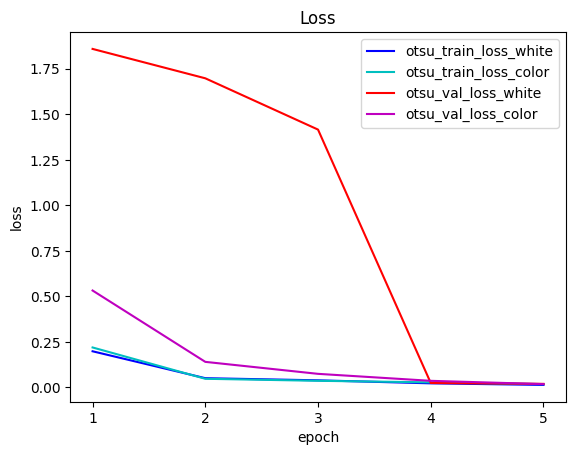

In [118]:
x = epochs = [1, 2, 3, 4, 5]
plt.plot(epochs, otsu_train_loss,  label = 'otsu_train_loss_white', color = 'b')
plt.plot(epochs, otsu_train_loss_color,  label = 'otsu_train_loss_color', color = 'c')
plt.plot(epochs, otsu_val_loss,  label = 'otsu_val_loss_white', color = 'r')
plt.plot(epochs, otsu_val_loss_color,  label = 'otsu_val_loss_color', color = 'm')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

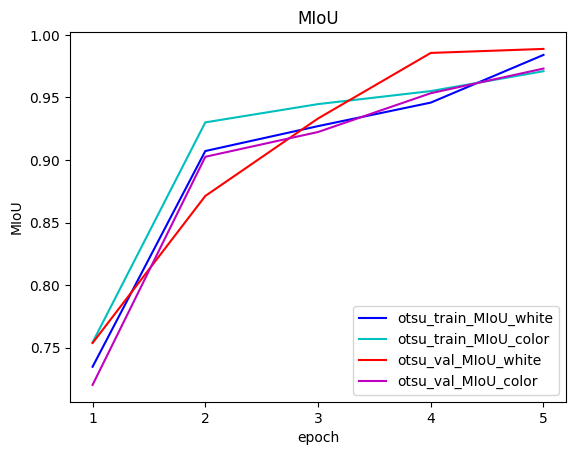

In [129]:
x = epochs = [1, 2, 3, 4, 5]
plt.plot(epochs, otsu_train_MIoU,  label = 'otsu_train_MIoU_white', color = 'b')
plt.plot(epochs, otsu_train_MIoU_color,  label = 'otsu_train_MIoU_color', color = 'c')
plt.plot(epochs, otsu_val_MIoU,  label = 'otsu_val_MIoU_white', color = 'r')
plt.plot(epochs, otsu_val_MIoU_color,  label = 'otsu_val_MIoU_color', color = 'm')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title("MIoU")
plt.ylabel("MIoU")
plt.xlabel("epoch")
plt.legend()
plt.show()

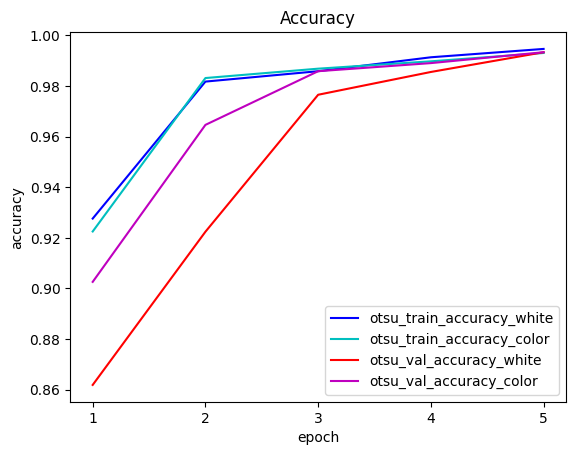

In [124]:
x = epochs = [1, 2, 3, 4, 5]
plt.plot(epochs, otsu_train_accuracy,  label = 'otsu_train_accuracy_white', color = 'b')
plt.plot(epochs, otsu_train_accuracy_color,  label = 'otsu_train_accuracy_color', color = 'c')
plt.plot(epochs, otsu_val_accuracy,  label = 'otsu_val_accuracy_white', color = 'r')
plt.plot(epochs, otsu_val_accuracy_color,  label = 'otsu_val_accuracy_color', color = 'm')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

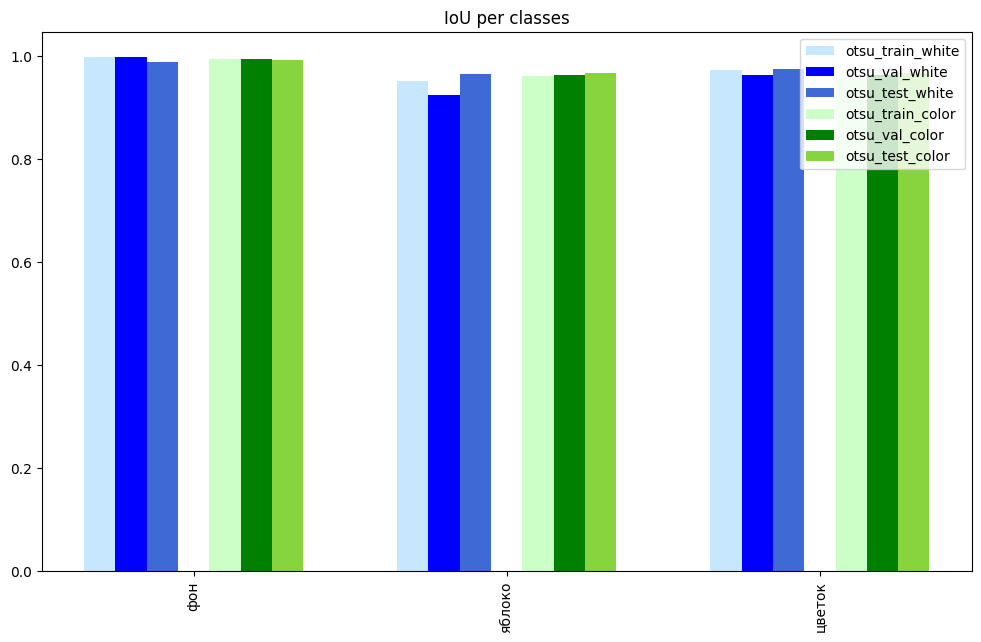

In [41]:
x_axis = np.arange(len(CLASSES))
plt.figure(figsize = (12, 7))
plt.title('IoU per classes')
plt.bar(x_axis-0.3, otsu_train_pclIOU, width=0.1, color='#c7e7ff', label='otsu_train_white')
plt.bar(x_axis-0.2, otsu_val_pclIOU, width=0.1, color='b', label='otsu_val_white')
plt.bar(x_axis-0.1, otsu_test_pclIOU, width=0.1, color='#3f69d4', label='otsu_test_white')
plt.bar(x_axis+0.1, IOU_pcl_train_color, width=0.1, color='#cbffc7', label='otsu_train_color')
plt.bar(x_axis+0.2, IOU_pcl_val_color, width=0.1, color='g', label='otsu_val_color')
plt.bar(x_axis+0.3, IOU_pcl_test_color, width=0.1, color='#87d43f', label='otsu_test_color')
plt.xticks(x_axis, CLASSES, rotation=90)
plt.legend()
plt.show()

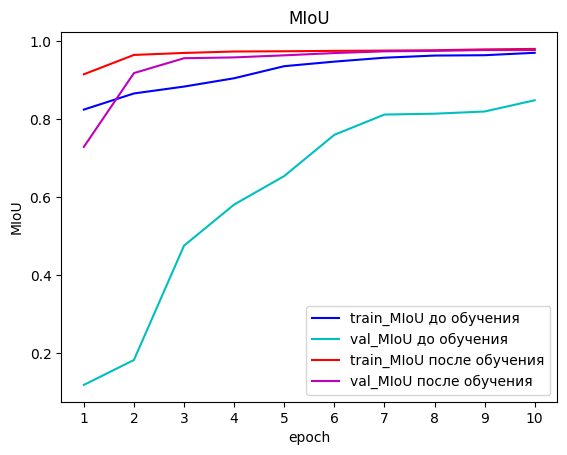

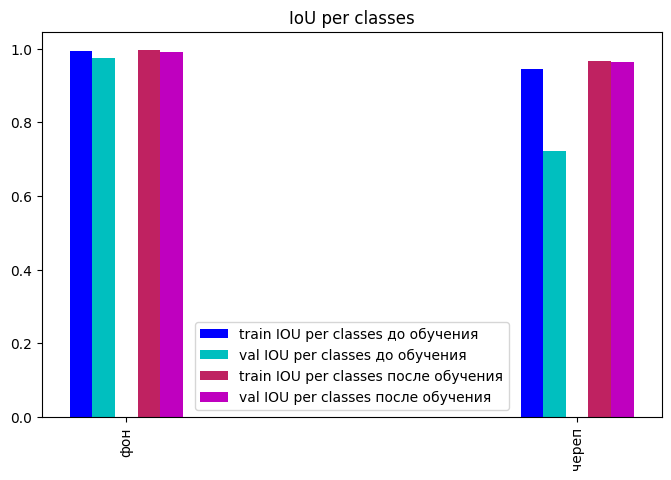

In [33]:
CLASSES = [
    'фон',
    'череп'

]

MIoU = [0.8240, 0.8653, 0.8829, 0.9042, 0.9351, 0.9468, 0.9568, 0.9623, 0.9632, 0.9694]
val_MIoU = [0.1192, 0.1830, 0.4757, 0.5809, 0.6539, 0.7594, 0.8113, 0.8135, 0.8191, 0.8479]
IOU_per_classes = [0.9947,  0.9440] 
val_IOU_per_classes = [0.9741, 0.7218]

new_MIoU = [0.9143, 0.9639, 0.9690, 0.9727, 0.9733, 0.9743, 0.9750, 0.9759, 0.9781, 0.9793]
new_val_MIoU = [0.7284, 0.9174, 0.9555, 0.9576, 0.9629, 0.9687, 0.9731, 0.9743, 0.9764, 0.9766]
new_IOU_per_classes = [0.9955,  0.9671] 
new_val_IOU_per_classes = [0.9901,  0.9632]


x = epochs = np.arange(1, 11)
plt.plot(epochs, MIoU,  label = 'train_MIoU до обучения', color = 'b')
plt.plot(epochs, val_MIoU,  label = 'val_MIoU до обучения', color = 'c')
plt.plot(epochs, new_MIoU,  label = 'train_MIoU после обучения', color = 'r')
plt.plot(epochs, new_val_MIoU,  label = 'val_MIoU после обучения', color = 'm')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title("MIoU")
plt.ylabel("MIoU")
plt.xlabel("epoch")
plt.legend()
plt.show()


x_axis = np.arange(len(CLASSES))
plt.figure(figsize = (8, 5))
plt.title('IoU per classes')
plt.bar(x_axis-0.10, IOU_per_classes, width=0.05, color='b', label='train IOU per classes до обучения')
plt.bar(x_axis-0.05, val_IOU_per_classes, width=0.05, color='c', label='val IOU per classes до обучения')
plt.bar(x_axis+0.05, new_IOU_per_classes, width=0.05, color='#bf2261', label='train IOU per classes после обучения')
plt.bar(x_axis+0.10, new_val_IOU_per_classes, width=0.05, color='m', label='val IOU per classes после обучения')
plt.xticks(x_axis, CLASSES, rotation=90)
plt.legend()
plt.show()

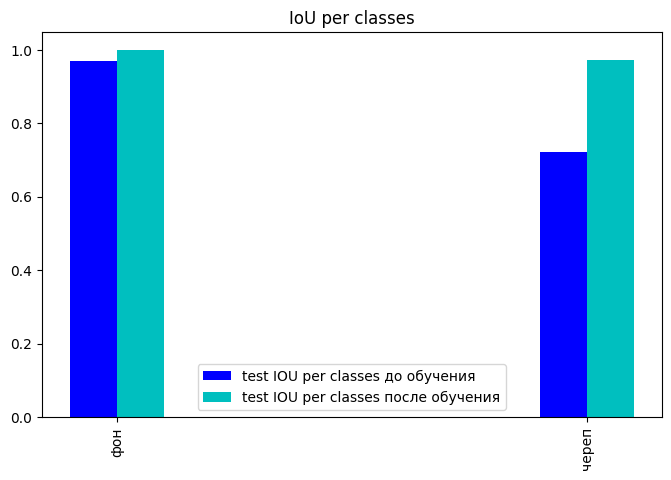

In [37]:
old =[ 0.968409711845343, 0.7220557873574927]
new = [0.998409711845343, 0.9720557873574927]

x_axis = np.arange(len(CLASSES))
plt.figure(figsize = (8, 5))
plt.title('IoU per classes')
plt.bar(x_axis-0.05, old, width=0.1, color='b', label='test IOU per classes до обучения')
plt.bar(x_axis+0.05, new, width=0.1, color='c', label='test IOU per classes после обучения')
plt.xticks(x_axis, CLASSES, rotation=90)
plt.legend()
plt.show()


# Дообучение

In [14]:
import os

dead_files = []
alive_files = []

for i in range(1, 101):
    f = f"C:/Users/iraor/PycharmProjects/FusionBrainGen/skeletons/original/{i}.png"
    if not(os.path.exists(f)):
        # print(f"не хватает image{i}")
        dead_files.append(i)
    else: 
        # print(f"есть image{i}")
        alive_files.append(i)
print(dead_files)
    
    

[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [6]:
def kmeans_img(image, mcolor):
    z = image.reshape((-1, 3))
    # convert to np.float32
    z = np.float32(z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k = 2
    ret, label, center = cv2.kmeans(z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape(image.shape)

    pix = list(res2[10, 10])
    img = res2

    for i in range(res2.shape[0]):
        for j in range(res2.shape[1]):
            if (list(res2[i, j])[0] > pix[0]) and (list(res2[i, j])[1] > pix[1]) and (list(res2[i, j])[2] > pix[2]):
                pix = list(res2[i, j])
                break

    for i in range(res2.shape[0]):
        for j in range(res2.shape[1]):
            if list(res2[i, j]) != pix:
                img[i, j] = [0, 0, 0]
            else:
                img[i, j] = list(mcolor)
    return img


def grey_img(image):
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return img_grey


for i in range(1000):
    image = cv2.imread(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/images/scull/grey/image{i}.png")
    km = kmeans_img(image, (255,0,0))
    cv2.imwrite(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/images/scull/_kmeans/image{i}.png", km)



In [50]:
import cv2

for i in range(100):
    image = cv2.imread(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/flowers/mask/image{i}.png")
    for l in range(512):
        for k in range(512):
            if (list(image[l,k]) == [83, 50, 250]) or (list(image[l,k]) == [204, 156, 253])  or (list(image[l,k]) == [144, 85, 91]):
                pass
            else: image[l,k] = [0,0,0]
    cv2.imwrite(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/flowers/mask/image{i}.png", image)

In [15]:
import os

for i in range(100):
    os.rename(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/flowers1/original/image{i}.png", 
             f"C:/Users/iraor/PycharmProjects/FusionBrainGen/flowers1/original/image{i+100}.png")
    os.rename(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/flowers1/mask/image{i}.png", 
             f"C:/Users/iraor/PycharmProjects/FusionBrainGen/flowers1/mask/image{i+100}.png")
    os.rename(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/flowers1/mask_color/image{i}.png", 
             f"C:/Users/iraor/PycharmProjects/FusionBrainGen/flowers1/mask_color/image{i+100}.png")

In [11]:
import cv2
for i in range(514):
    image = cv2.imread(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/backs/image{i}.png")
    res = cv2.resize(image, [512, 512], cv2.INTER_AREA)
    cv2.imwrite(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/backs/image{i}.png", res)



In [49]:
import cv2

for i in range(100):
    image = cv2.imread(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/flowers/img/image{i}.png")
    mask = cv2.imread(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/flowers/mask/image{i}.png")
    back = image.copy()
    for l in range(512):
        for k in range(512):
            if (list(mask[l,k]) == [83, 50, 250]) or (list(mask[l,k]) == [204, 156, 253])  or (list(mask[l,k]) == [144, 85, 91]):
                back[l,k] = [0,0,0]
    cv2.imwrite(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/flowers/backs/image{i}.png", back)

In [13]:
import cv2

for i in range(1000):
    image = cv2.imread(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes/mask_color/image{i}.png")
    for l in range(512):
        for k in range(512):
            if (list(image[l,k]) == [204, 156, 253]):
                image[l,k] = [1, 1, 1]
            elif (list(image[l,k]) == [144, 85, 91]):  
                image[l,k] = [2, 2, 2]
            elif(list(image[l,k]) == [83, 50, 250]):
                image[l,k] = [3, 3, 3]
            
    cv2.imwrite(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes/mask/image{i}.png", image)

TypeError: 'NoneType' object is not subscriptable

In [14]:
import cv2

for i in range(1000):
    image = cv2.imread(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes/mask/image{i}.png")
    for l in range(512):
        for k in range(512):
            if (list(image[l,k]) == [1, 1, 1]) or (list(image[l,k]) == [2, 2, 2])  or (list(image[l,k]) == [3, 3, 3]):
                pass
            else: image[l,k] = [0,0,0]
    cv2.imwrite(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes/mask/image{i}.png", image)